## Importing libraries and loading dataset

In [1]:
import pandas as pd
import numpy as np
import optuna 
from optuna import study

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt


import matplotlib.pyplot as plt
plt.style.use('Solarize_Light2')

from catboost import CatBoostRegressor
import optuna

import warnings
warnings.filterwarnings('ignore')

In [2]:
input_dir = 'C:/Users/vadim.sokolov/Desktop/В/test5/'
timeseries_df = pd.read_excel(f'{input_dir}BurgerKing_TimeSeries_TEST.xlsx', 
                              sheet_name='TimeSeries')
calendar_df = pd.read_excel(f'{input_dir}BurgerKing_TimeSeries_TEST.xlsx', 
                            sheet_name='Calendar')

In [3]:
def check_df(dataframe):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(3))
    print("##################### Tail #####################")
    print(dataframe.tail(3))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [4]:
check_df(timeseries_df)

##################### Shape #####################
(10016, 4)
##################### Types #####################
key             int64
ds     datetime64[ns]
y               int64
ddd             int64
dtype: object
##################### Head #####################
   key         ds    y  ddd
0    1 2019-06-10    1  161
1    1 2019-06-11   14  162
2    1 2019-06-12  332  163
##################### Tail #####################
       key         ds    y  ddd
10013    5 2023-07-29  941  210
10014    5 2023-07-30  996  211
10015    5 2023-07-31  932  212
##################### NA #####################
key    0
ds     0
y      0
ddd    0
dtype: int64
##################### Quantiles #####################
     0.00    0.05   0.50    0.95     0.99    1.00
key   1.0    1.00    3.0     5.0     5.00     5.0
y     1.0  214.75  639.0  1249.0  1822.55  2268.0
ddd   1.0   18.00  177.0   347.0   362.00   366.0


In [5]:
check_df(calendar_df)

##################### Shape #####################
(3288, 13)
##################### Types #####################
day_id             datetime64[ns]
week_id                     int64
month_id                    int64
year_id                     int64
day_year                    int64
day_week                    int64
day_number                  int64
week_number                 int64
month_number                int64
quarter_number              int64
is_holiday                  int64
is_warm                     int64
is_black_friday             int64
dtype: object
##################### Head #####################
      day_id  week_id  month_id  year_id  day_year  day_week  day_number  \
0 2016-01-01   201553    201601     2016         1         5           1   
1 2016-01-02   201553    201601     2016         2         6           2   
2 2016-01-03   201553    201601     2016         3         7           3   

   week_number  month_number  quarter_number  is_holiday  is_warm  \
0         

In [6]:
items_in_data = timeseries_df.key.unique()
print(items_in_data)
print("Number of items in the dataset: " + str(len(items_in_data)))

[1 2 3 4 5]
Number of items in the dataset: 5


In [7]:
timeseries_df.isnull().sum()

key    0
ds     0
y      0
ddd    0
dtype: int64

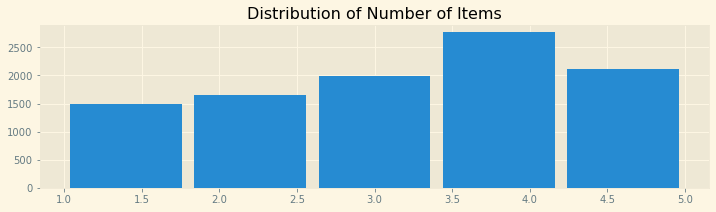

4    2764
5    2106
3    1996
2    1653
1    1497
Name: key, dtype: int64


In [8]:
fig = plt.figure(figsize = (12,3))
plt.hist(timeseries_df.key, rwidth = 0.9, bins = len(timeseries_df.key.unique()))
plt.title('Distribution of Number of Items')
plt.show()
print(timeseries_df.key.value_counts())

In [9]:
# удаление строк из df с самыми ранними продажами магаинов (не считаем первые 14 дней).

timeseries_df.sort_values(by=['key','ds'], axis=0, inplace=True)
timeseries_df['days_in_sales'] = timeseries_df.groupby('key').cumcount()
timeseries_df.drop(timeseries_df[timeseries_df.days_in_sales < 14].index, inplace=True)
timeseries_df['days_in_sales'] = timeseries_df.groupby('key').cumcount()

In [10]:
timeseries_df.sort_values(by=['key','ds'], inplace=True)

timeseries_df = (timeseries_df.groupby(['key'])
                 .apply(lambda x: x.set_index('ds').resample('D').ffill()))
timeseries_df = timeseries_df.reset_index(level=0, drop=True).reset_index()
timeseries_df

ds  key     y  ddd  days_in_sales
0     2019-06-24    1  1214  175              0
1     2019-06-25    1  1065  176              1
2     2019-06-26    1  1184  177              2
3     2019-06-27    1  1162  178              3
4     2019-06-28    1  1273  179              4
...          ...  ...   ...  ...            ...
10080 2023-07-27    5   982  208           2087
10081 2023-07-28    5   949  209           2088
10082 2023-07-29    5   941  210           2089
10083 2023-07-30    5   996  211           2090
10084 2023-07-31    5   932  212           2091

[10085 rows x 5 columns]

In [11]:
# Добавление аномальных периодов.
from datetime import datetime as dt

def anomal_periods(timeseries_df):
    if (timeseries_df['ds'] >= dt.strptime('2020-03-15', "%Y-%m-%d")) & (
        timeseries_df['ds'] < dt.strptime('2020-07-31', "%Y-%m-%d")):
        return 'COVID-19'
    elif (timeseries_df['ds'] >= dt.strptime('2021-06-12', "%Y-%m-%d")) & (
        timeseries_df['ds'] < dt.strptime('2021-07-31', "%Y-%m-%d")):
        return 'QR-codes'
    elif (timeseries_df['ds'] >= dt.strptime('2021-10-26', "%Y-%m-%d")) & (
        timeseries_df['ds'] < dt.strptime('2021-11-12', "%Y-%m-%d")):
        return 'lockdown'
    else:
        return 'None'

timeseries_df['anomal_periods'] = timeseries_df.apply(anomal_periods, axis=1)

In [12]:
# Приравниваем к 0 продажи в периоды аномальных дней.

def conditions(timeseries_df):
    if timeseries_df['anomal_periods'] == 'None':
        return timeseries_df['y']
    else:
        return 0

timeseries_df['y'] = timeseries_df.apply(lambda x: conditions(x), axis=1)
timeseries_df

ds  key     y  ddd  days_in_sales anomal_periods
0     2019-06-24    1  1214  175              0           None
1     2019-06-25    1  1065  176              1           None
2     2019-06-26    1  1184  177              2           None
3     2019-06-27    1  1162  178              3           None
4     2019-06-28    1  1273  179              4           None
...          ...  ...   ...  ...            ...            ...
10080 2023-07-27    5   982  208           2087           None
10081 2023-07-28    5   949  209           2088           None
10082 2023-07-29    5   941  210           2089           None
10083 2023-07-30    5   996  211           2090           None
10084 2023-07-31    5   932  212           2091           None

[10085 rows x 6 columns]

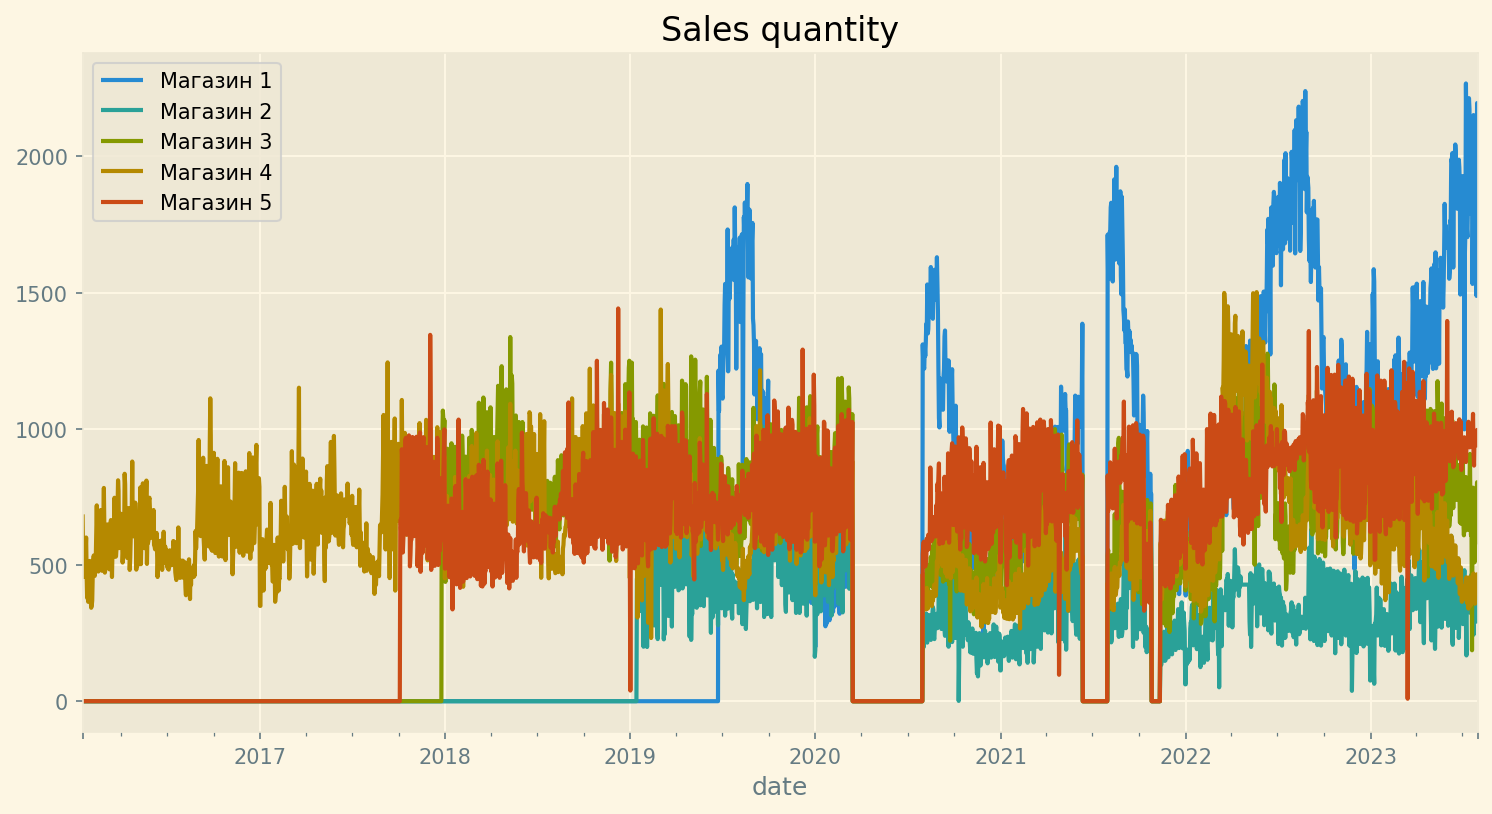

In [13]:
timeseries = timeseries_df[['ds','key','y']]
timeseries_1 = timeseries.pivot_table('y', ['ds'], 'key').fillna(0)

plt.figure(figsize=(12, 6), dpi=150)

timeseries_1.iloc[:,0].plot(label = 'Магазин 1')
timeseries_1.iloc[:,1].plot(label = 'Магазин 2')
timeseries_1.iloc[:,2].plot(label = 'Магазин 3')
timeseries_1.iloc[:,3].plot(label = 'Магазин 4')
timeseries_1.iloc[:,4].plot(label = 'Магазин 5')

plt.title('Sales quantity')
plt.xlabel('date')
plt.legend(loc='upper left')

In [14]:
# замена строк с аномальными периодами (0 продажи) на значения (pchip - monotonic cubic splines to find value of new points).

from scipy.interpolate import pchip

y = np.array(timeseries_df['y'])
x = np.arange(len(y))
idx = np.where(y!=0)
f = pchip(x[idx],y[idx])

y_interp = pd.DataFrame(f(x), columns=['y_interp1'])

timeseries_df = timeseries_df.merge(y_interp, left_index=True, right_index=True, how = 'left')

timeseries_df

ds  key     y  ddd  days_in_sales anomal_periods  y_interp1
0     2019-06-24    1  1214  175              0           None     1214.0
1     2019-06-25    1  1065  176              1           None     1065.0
2     2019-06-26    1  1184  177              2           None     1184.0
3     2019-06-27    1  1162  178              3           None     1162.0
4     2019-06-28    1  1273  179              4           None     1273.0
...          ...  ...   ...  ...            ...            ...        ...
10080 2023-07-27    5   982  208           2087           None      982.0
10081 2023-07-28    5   949  209           2088           None      949.0
10082 2023-07-29    5   941  210           2089           None      941.0
10083 2023-07-30    5   996  211           2090           None      996.0
10084 2023-07-31    5   932  212           2091           None      932.0

[10085 rows x 7 columns]

In [15]:
timeseries_df['y_interp1'].isnull().value_counts()

False    10085
Name: y_interp1, dtype: int64

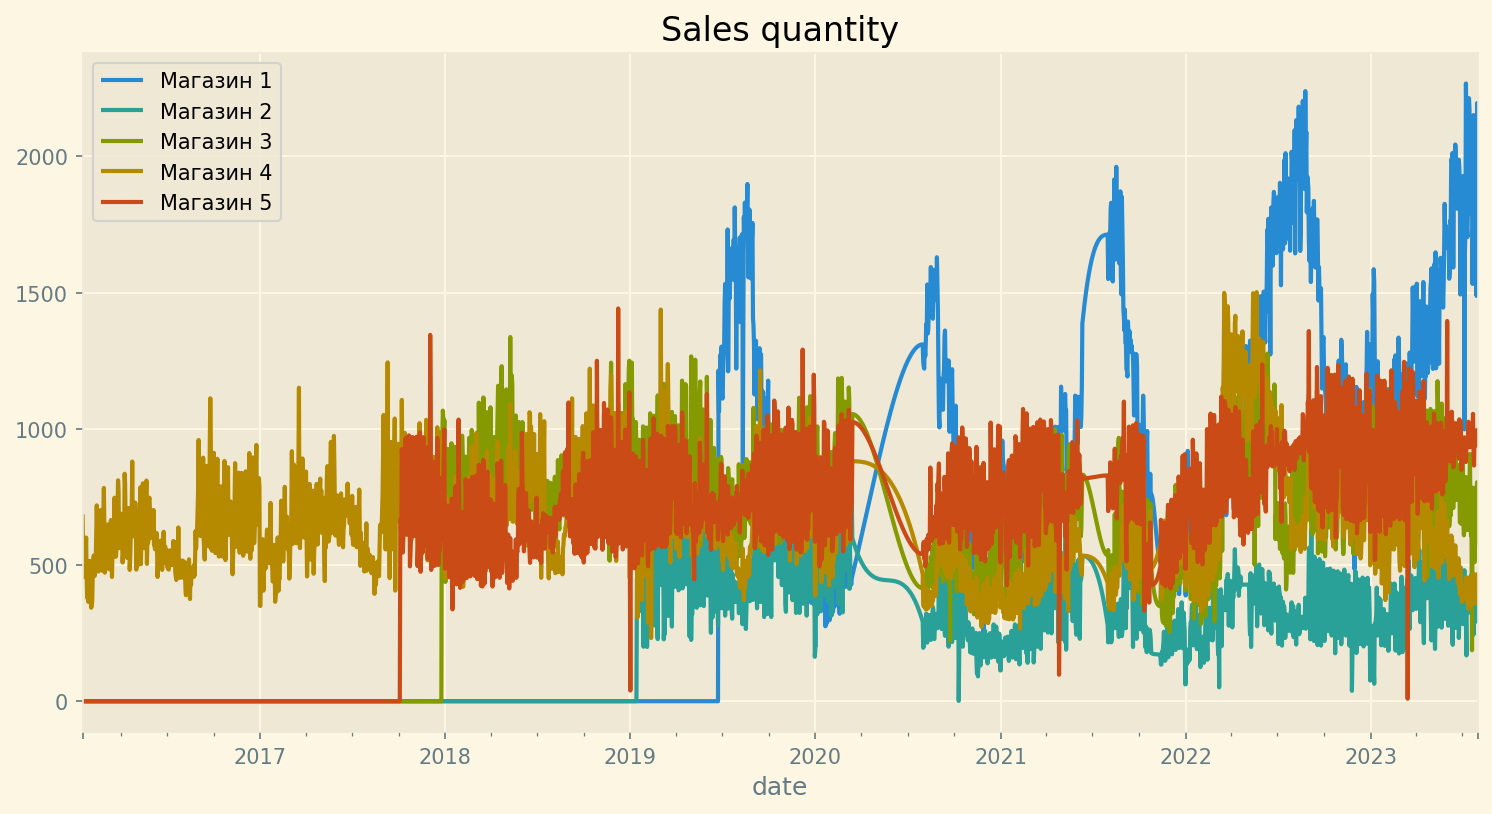

In [16]:
timeseries = timeseries_df.query('key!=0')[['ds','key','y_interp1']]
timeseries_1 = timeseries.pivot_table('y_interp1', ['ds'], 'key').fillna(0)

plt.figure(figsize=(12, 6), dpi=150)

timeseries_1.iloc[:,0].plot(label = 'Магазин 1')
timeseries_1.iloc[:,1].plot(label = 'Магазин 2')
timeseries_1.iloc[:,2].plot(label = 'Магазин 3')
timeseries_1.iloc[:,3].plot(label = 'Магазин 4')
timeseries_1.iloc[:,4].plot(label = 'Магазин 5')

plt.title('Sales quantity')
plt.xlabel('date')
plt.legend(loc='upper left')

In [17]:
timeseries = timeseries_df.set_index('ds')

### Time Series Decomposition

<Figure size 432x288 with 0 Axes>

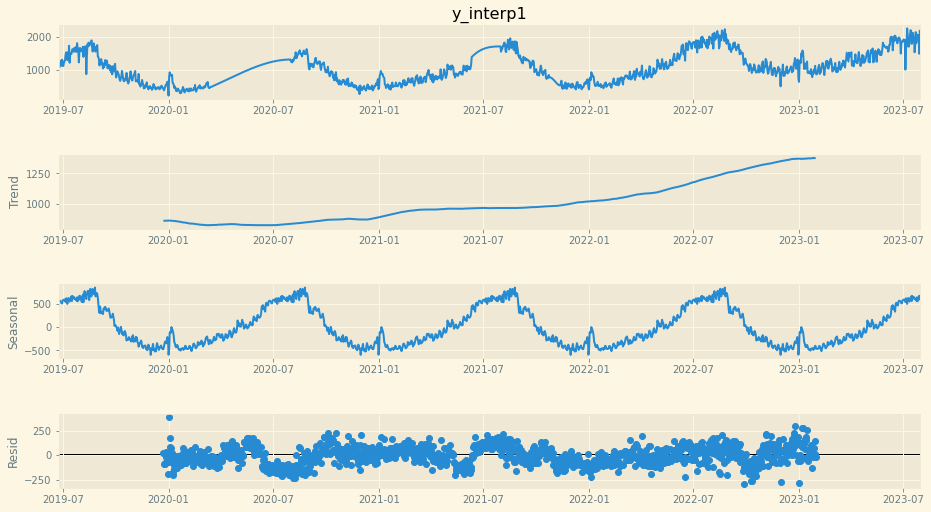

In [18]:
# Yearly trend/seasonality/residuals

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

decomp = seasonal_decompose(timeseries.query('key==1')['y_interp1'], model = 'additive', period = 365) # выбрать магазин
                                                                                                       #- key==?
fig = plt.figure()
fig = decomp.plot()
fig.set_size_inches(15,8)

<Figure size 432x288 with 0 Axes>

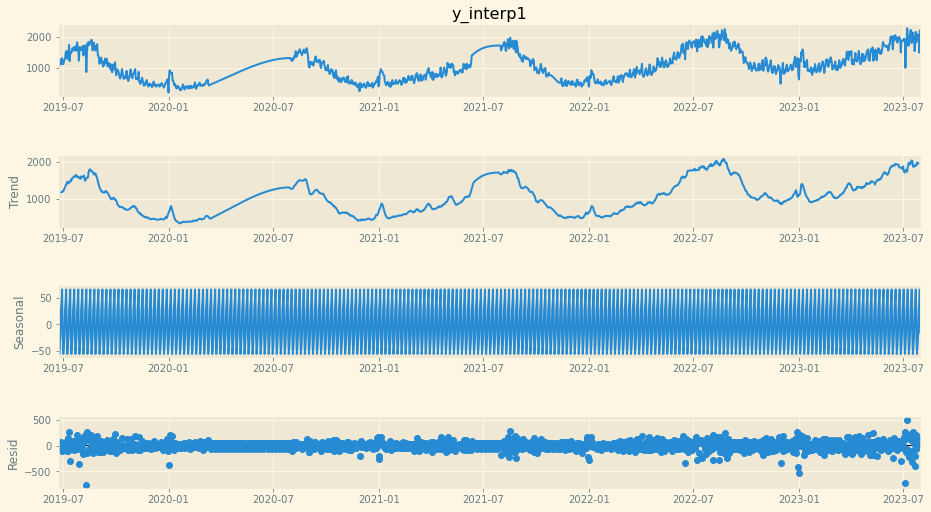

In [19]:
# Weekly trend/seasonality/residuals

decomp = seasonal_decompose(timeseries.query('key==1')['y_interp1'], model = 'additive', period = 7)

fig = plt.figure()
fig = decomp.plot()
fig.set_size_inches(15,8)

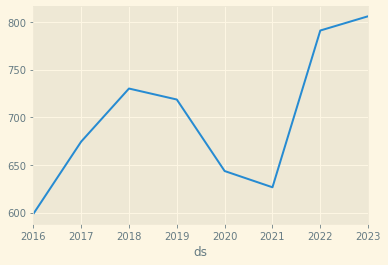

In [20]:
# тренд для всех магазинов суммарно.
week_timeseries = timeseries.query('key!=0')['y_interp1'].resample('W').mean()
year_timeseries = timeseries.query('key!=0')['y_interp1'].resample('Y').mean()

components_week = sm.tsa.seasonal_decompose(week_timeseries, model = 'additive')
components_year = sm.tsa.seasonal_decompose(year_timeseries, model = 'additive')

#components_week.trend.plot()
components_year.trend.plot()
plt.show()

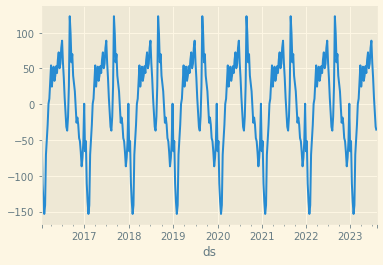

In [21]:
# сезонность 
components_week.seasonal.plot()

#residuals
#components_week.resid.plot()
plt.show()

In [22]:
# Определяем residuals в разрезе недели и года для дальнейшего выявления outliers.

segments = set(timeseries['key'])
data = pd.DataFrame([])
for s in segments:
    df = timeseries[timeseries['key'] == s]#.set_index('day_id') #.resample('H').mean()
    decomp_w = sm.tsa.seasonal_decompose(x=df['y_interp1'], model = 'additive', period = 52)
    decomp_y = sm.tsa.seasonal_decompose(x=df['y_interp1'], model = 'additive', period = 365)
    df = df.join(decomp_w.resid, how='left', lsuffix='_left', rsuffix='_right').join(decomp_y.resid, how='left', lsuffix='_left', rsuffix='_right')    #df.join(decomp.trend).join(decomp.seasonal).join(decomp.resid)
    
    df = df.rename(columns={'resid_left': 'resid_w', 'resid_right': 'resid_y'})

#optional columns with some statistics to find outliers and trend changes
    #df['resid_zscore_week'] = (df['resid_w'] - df['resid_w'].mean()).div(df['resid_w'].std())
    #df['resid_zscore_year'] = (df['resid_y'] - df['resid_y'].mean()).div(df['resid_y'].std())
    #df['trend_change'] = df.trend.pct_change()
    #df['trend_change_zscore'] = (df['trend_change'] - df['trend_change'].mean()).div(df['trend_change'].std())
    
    data = data.append(df)
data

key     y  ddd  days_in_sales anomal_periods  y_interp1  resid_w  \
ds                                                                             
2019-06-24    1  1214  175              0           None     1214.0      NaN   
2019-06-25    1  1065  176              1           None     1065.0      NaN   
2019-06-26    1  1184  177              2           None     1184.0      NaN   
2019-06-27    1  1162  178              3           None     1162.0      NaN   
2019-06-28    1  1273  179              4           None     1273.0      NaN   
...         ...   ...  ...            ...            ...        ...      ...   
2023-07-27    5   982  208           2087           None      982.0      NaN   
2023-07-28    5   949  209           2088           None      949.0      NaN   
2023-07-29    5   941  210           2089           None      941.0      NaN   
2023-07-30    5   996  211           2090           None      996.0      NaN   
2023-07-31    5   932  212           2091           None      932.0      NaN   

            resid_y  
ds                   
2019-06-24      NaN  
2019-06-25      NaN  
2019-06-26      NaN  
2019-06-27      NaN  
2019-06-28      NaN  
...             ...  
2023-07-27      NaN  
2023-07-28      NaN  
2023-07-29      NaN  
2023-07-30      NaN  
2023-07-31      NaN  

[10085 rows x 8 columns]

In [23]:
# Interquartile range method for week and year

segments = set(data['key'])
ts_df = pd.DataFrame([])
for s in segments:
    df = data[data['key'] == s]
    df['Q1_w'] = df['resid_w'].quantile(0.25)
    df['Q3_w'] = df['resid_w'].quantile(0.75)
    df['IQR_w'] = df['Q3_w'] - df['Q1_w']
    df['lower_w'] = df['Q1_w'] - 1.5 * df['IQR_w']
    df['upper_w'] = df['Q3_w'] + 1.5 * df['IQR_w']
    
    df['Q1_y'] = df['resid_y'].quantile(0.25)
    df['Q3_y'] = df['resid_y'].quantile(0.75)
    df['IQR_y'] = df['Q3_y'] - df['Q1_y']
    df['lower_y'] = df['Q1_y'] - 1.5 * df['IQR_y']
    df['upper_y'] = df['Q3_y'] + 1.5 * df['IQR_y']
    
    ts_df = ts_df.append(df)

ts_df.drop(['Q1_w','Q3_w','IQR_w','Q1_y','Q3_y','IQR_y'], axis=1, inplace=True)
ts_df.fillna(0,inplace=True)
ts_df

key     y  ddd  days_in_sales anomal_periods  y_interp1  resid_w  \
ds                                                                             
2019-06-24    1  1214  175              0           None     1214.0      0.0   
2019-06-25    1  1065  176              1           None     1065.0      0.0   
2019-06-26    1  1184  177              2           None     1184.0      0.0   
2019-06-27    1  1162  178              3           None     1162.0      0.0   
2019-06-28    1  1273  179              4           None     1273.0      0.0   
...         ...   ...  ...            ...            ...        ...      ...   
2023-07-27    5   982  208           2087           None      982.0      0.0   
2023-07-28    5   949  209           2088           None      949.0      0.0   
2023-07-29    5   941  210           2089           None      941.0      0.0   
2023-07-30    5   996  211           2090           None      996.0      0.0   
2023-07-31    5   932  212           2091           None      932.0      0.0   

            resid_y     lower_w     upper_w     lower_y     upper_y  
ds                                                                   
2019-06-24      0.0 -295.906681  286.708357 -273.704130  264.614966  
2019-06-25      0.0 -295.906681  286.708357 -273.704130  264.614966  
2019-06-26      0.0 -295.906681  286.708357 -273.704130  264.614966  
2019-06-27      0.0 -295.906681  286.708357 -273.704130  264.614966  
2019-06-28      0.0 -295.906681  286.708357 -273.704130  264.614966  
...             ...         ...         ...         ...         ...  
2023-07-27      0.0 -362.125608  340.160202 -370.450445  367.534922  
2023-07-28      0.0 -362.125608  340.160202 -370.450445  367.534922  
2023-07-29      0.0 -362.125608  340.160202 -370.450445  367.534922  
2023-07-30      0.0 -362.125608  340.160202 -370.450445  367.534922  
2023-07-31      0.0 -362.125608  340.160202 -370.450445  367.534922  

[10085 rows x 12 columns]

In [24]:
# ВАРИАНТ 2 RESID_ZSCORE > 2 *FILTER
#def conditions(ts_df):
#    if (abs(ts_df['resid_zscore']) > 2): # or (abs(data['trend_change_zscore']) > 3):
#        return 0
#    else:
#        return ts_df['y']
#    
#ts_df['y_outl'] = ts_df.apply(lambda x: conditions(x), axis=1)

In [25]:
# приравниваем к 0 продажи в те дни, где есть outliers.

ts_df['y_interp2'] = np.where((ts_df['resid_w'] > ts_df['lower_w']) & (
    ts_df['resid_w'] < ts_df['upper_w']), ts_df['y_interp1'], 0)

ts_df['y_interp2'] = np.where((ts_df['resid_y'] > ts_df['lower_y']) & (
    ts_df['resid_y'] < ts_df['upper_y']), ts_df['y_interp1'], 0)

ts_df.sort_values(by=['key','ds'], inplace=True)

#def conditions(ts_df):
#    if (ts_df['days_in_sales'] < 30) or (
#        ts_df['resid'] < ts_df['lower']) or (
#        ts_df['resid'] > ts_df['upper']):
#        return 0
#    else:
#        return ts_df['y_interp1']
#
#ts_df['y_interp2'] = ts_df.apply(lambda x: conditions(x), axis=1)

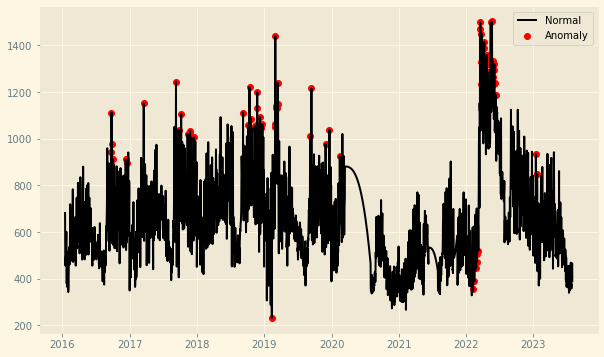

In [26]:
# визуализация магазинов с аномальными выбросами.

fig, ax = plt.subplots(figsize=(10,6))
data_scale = ts_df.query('key==4')[['y_interp1','y_interp2']]
a = data_scale.loc[data_scale['y_interp2'] == 0, ['y_interp1']] #anomaly
ax.plot(data_scale.index, data_scale['y_interp1'], color='black', label = 'Normal')
ax.scatter(a.index, a['y_interp1'], color='red', label = 'Anomaly')
plt.legend()
plt.show()

In [27]:
ts_df['y_interp2'].sum()/ts_df['y_interp1'].sum()-1

-0.01898538306739861

In [28]:
# замена строк с outliers (0 продажи) на значения (monotonic cubic splines to find the value of new points)

y = np.array(ts_df['y_interp2'])
x = np.arange(len(y))
idx = np.where(y!=0)
f = pchip(x[idx],y[idx])

y_interp3 = pd.DataFrame(f(x), columns=['y_interp3'])

ts_df = pd.merge(ts_df.reset_index(), y_interp3, left_index=True, right_index=True, how = 'left')
ts_df

ds  key     y  ddd  days_in_sales anomal_periods  y_interp1  \
0     2019-06-24    1  1214  175              0           None     1214.0   
1     2019-06-25    1  1065  176              1           None     1065.0   
2     2019-06-26    1  1184  177              2           None     1184.0   
3     2019-06-27    1  1162  178              3           None     1162.0   
4     2019-06-28    1  1273  179              4           None     1273.0   
...          ...  ...   ...  ...            ...            ...        ...   
10080 2023-07-27    5   982  208           2087           None      982.0   
10081 2023-07-28    5   949  209           2088           None      949.0   
10082 2023-07-29    5   941  210           2089           None      941.0   
10083 2023-07-30    5   996  211           2090           None      996.0   
10084 2023-07-31    5   932  212           2091           None      932.0   

       resid_w  resid_y     lower_w     upper_w     lower_y     upper_y  \
0          0.0      0.0 -295.906681  286.708357 -273.704130  264.614966   
1          0.0      0.0 -295.906681  286.708357 -273.704130  264.614966   
2          0.0      0.0 -295.906681  286.708357 -273.704130  264.614966   
3          0.0      0.0 -295.906681  286.708357 -273.704130  264.614966   
4          0.0      0.0 -295.906681  286.708357 -273.704130  264.614966   
...        ...      ...         ...         ...         ...         ...   
10080      0.0      0.0 -362.125608  340.160202 -370.450445  367.534922   
10081      0.0      0.0 -362.125608  340.160202 -370.450445  367.534922   
10082      0.0      0.0 -362.125608  340.160202 -370.450445  367.534922   
10083      0.0      0.0 -362.125608  340.160202 -370.450445  367.534922   
10084      0.0      0.0 -362.125608  340.160202 -370.450445  367.534922   

       y_interp2  y_interp3  
0         1214.0     1214.0  
1         1065.0     1065.0  
2         1184.0     1184.0  
3         1162.0     1162.0  
4         1273.0     1273.0  
...          ...        ...  
10080      982.0      982.0  
10081      949.0      949.0  
10082      941.0      941.0  
10083      996.0      996.0  
10084      932.0      932.0  

[10085 rows x 15 columns]

In [29]:
ts_df[ts_df['y_interp3'] == 0]

Empty DataFrame
Columns: [ds, key, y, ddd, days_in_sales, anomal_periods, y_interp1, resid_w, resid_y, lower_w, upper_w, lower_y, upper_y, y_interp2, y_interp3]
Index: []

<AxesSubplot:>

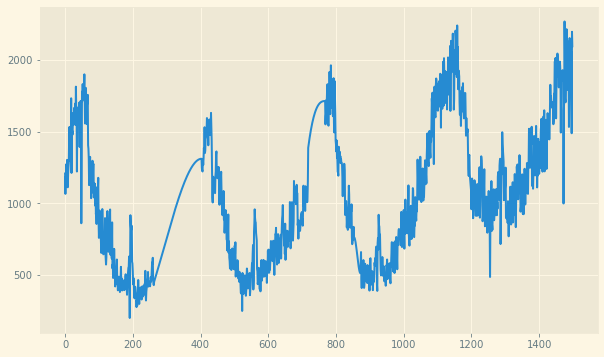

In [30]:
fig, ax = plt.subplots(figsize=(10,6))
data_scale = ts_df.query('key==1')['y_interp3']
data_scale.plot()                          

In [31]:
ts_df.drop(['anomal_periods','y_interp1','resid_w','resid_y','lower_w','upper_w','y_interp2'], axis=1, inplace=True)

In [32]:
ts_df['y'].isnull().value_counts()

False    10085
Name: y, dtype: int64

In [33]:
df2 = pd.merge(ts_df, calendar_df, left_on='ds', right_on='day_id', how='left')
df2.sort_values(by=['key','day_id'], inplace=True)
df2.drop(['ds'], axis=1, inplace=True)
df2

key     y  ddd  days_in_sales     lower_y     upper_y  y_interp3  \
0        1  1214  175              0 -273.704130  264.614966     1214.0   
1        1  1065  176              1 -273.704130  264.614966     1065.0   
2        1  1184  177              2 -273.704130  264.614966     1184.0   
3        1  1162  178              3 -273.704130  264.614966     1162.0   
4        1  1273  179              4 -273.704130  264.614966     1273.0   
...    ...   ...  ...            ...         ...         ...        ...   
10080    5   982  208           2087 -370.450445  367.534922      982.0   
10081    5   949  209           2088 -370.450445  367.534922      949.0   
10082    5   941  210           2089 -370.450445  367.534922      941.0   
10083    5   996  211           2090 -370.450445  367.534922      996.0   
10084    5   932  212           2091 -370.450445  367.534922      932.0   

          day_id  week_id  month_id  year_id  day_year  day_week  day_number  \
0     2019-06-24   201926    201906     2019       175         1          24   
1     2019-06-25   201926    201906     2019       176         2          25   
2     2019-06-26   201926    201906     2019       177         3          26   
3     2019-06-27   201926    201906     2019       178         4          27   
4     2019-06-28   201926    201906     2019       179         5          28   
...          ...      ...       ...      ...       ...       ...         ...   
10080 2023-07-27   202330    202307     2023       208         4          27   
10081 2023-07-28   202330    202307     2023       209         5          28   
10082 2023-07-29   202330    202307     2023       210         6          29   
10083 2023-07-30   202330    202307     2023       211         7          30   
10084 2023-07-31   202331    202307     2023       212         1          31   

       week_number  month_number  quarter_number  is_holiday  is_warm  \
0               26             6               2           0        1   
1               26             6               2           0        1   
2               26             6               2           0        1   
3               26             6               2           0        1   
4               26             6               2           0        1   
...            ...           ...             ...         ...      ...   
10080           30             7               3           0        1   
10081           30             7               3           0        1   
10082           30             7               3           0        1   
10083           30             7               3           0        1   
10084           31             7               3           0        1   

       is_black_friday  
0                    0  
1                    0  
2                    0  
3                    0  
4                    0  
...                ...  
10080                0  
10081                0  
10082                0  
10083                0  
10084                0  

[10085 rows x 20 columns]

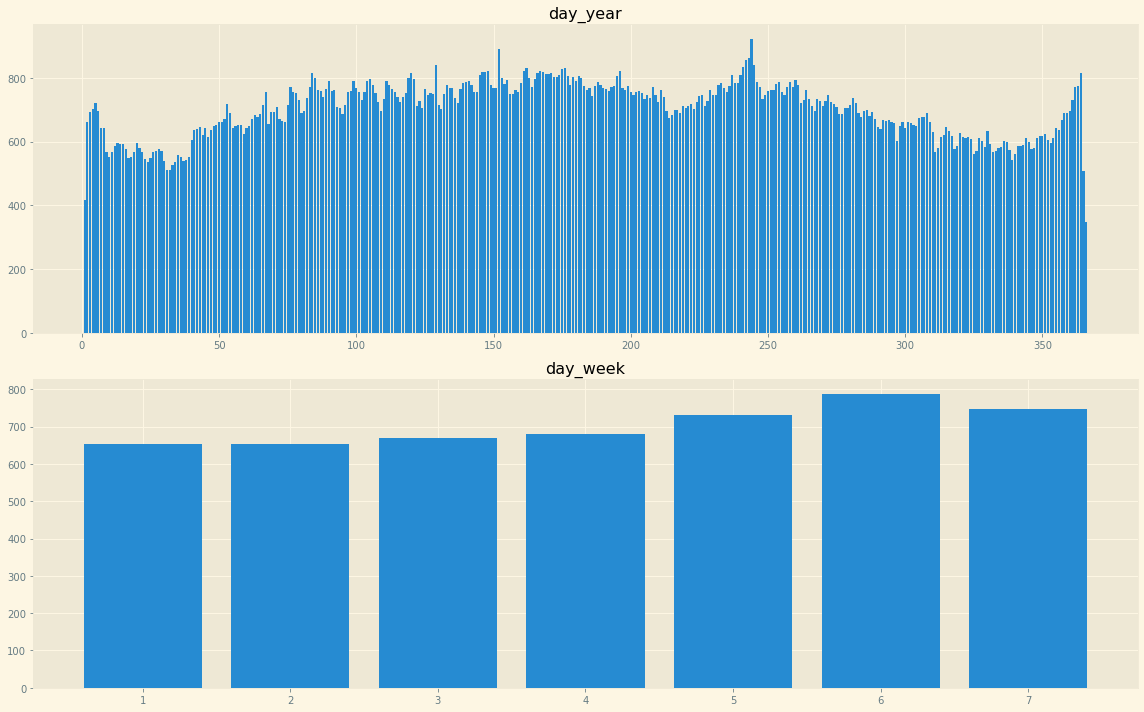

In [34]:
# сезонность внутри года, недели

nrows, ncols = 2,1 
fig, ax = plt.subplots(nrows, ncols, figsize=(16,10))

for i, col in enumerate(['day_year','day_week']): 
    plot_data = df2.query('key!=0').groupby(col)['y_interp3'].mean()
    
    cax = plt.subplot(nrows, ncols, i+1)
    cax.bar(plot_data.index, plot_data.values)
    # Need to add automatic adding of labels of x-axis
    cax.set_title('{}'.format(col, fontsize=10))

plt.tight_layout()
plt.show()

pd.options.mode.chained_assignment = 'warn'

In [35]:
# Создание тестового df для построения прогноза с 31.07.2023.

test1 = calendar_df.loc[calendar_df.day_id > pd.to_datetime('2023-07-31', format='%Y-%m-%d'),:].copy()
test2 = calendar_df.loc[calendar_df.day_id > pd.to_datetime('2023-07-31', format='%Y-%m-%d'),:].copy()
test3 = calendar_df.loc[calendar_df.day_id > pd.to_datetime('2023-07-31', format='%Y-%m-%d'),:].copy()
test4 = calendar_df.loc[calendar_df.day_id > pd.to_datetime('2023-07-31', format='%Y-%m-%d'),:].copy()
test5 = calendar_df.loc[calendar_df.day_id > pd.to_datetime('2023-07-31', format='%Y-%m-%d'),:].copy()

test1['key'] = 1
test2['key'] = 2
test3['key'] = 3
test4['key'] = 4
test5['key'] = 5

df = pd.concat([df2, test1, test2, test3, test4, test5], ignore_index=True)

In [36]:
def create_date_featues(df):
    df['is_wknd'] = df.day_id.dt.weekday//4
    df['is_month_start'] = df.day_id.dt.is_month_start.astype(int)
    df['is_month_end'] = df.day_id.dt.is_month_end.astype(int)
    return df

In [37]:
df = create_date_featues(df)
df.sort_values(by=['key','day_id'], axis=0, inplace=True)
df.head()

key       y    ddd  days_in_sales    lower_y     upper_y  y_interp3  \
0    1  1214.0  175.0            0.0 -273.70413  264.614966     1214.0   
1    1  1065.0  176.0            1.0 -273.70413  264.614966     1065.0   
2    1  1184.0  177.0            2.0 -273.70413  264.614966     1184.0   
3    1  1162.0  178.0            3.0 -273.70413  264.614966     1162.0   
4    1  1273.0  179.0            4.0 -273.70413  264.614966     1273.0   

      day_id  week_id  month_id  ...  day_number  week_number  month_number  \
0 2019-06-24   201926    201906  ...          24           26             6   
1 2019-06-25   201926    201906  ...          25           26             6   
2 2019-06-26   201926    201906  ...          26           26             6   
3 2019-06-27   201926    201906  ...          27           26             6   
4 2019-06-28   201926    201906  ...          28           26             6   

   quarter_number  is_holiday  is_warm  is_black_friday  is_wknd  \
0               2           0        1                0        0   
1               2           0        1                0        0   
2               2           0        1                0        0   
3               2           0        1                0        0   
4               2           0        1                0        1   

   is_month_start  is_month_end  
0               0             0  
1               0             0  
2               0             0  
3               0             0  
4               0             0  

[5 rows x 23 columns]

## Random Noise

In [38]:
def random_noise(df):
    return np.random.normal(size = (len(df),))

## Lag/Shifted features

In [39]:
def lag_features(df, lags):
    df = df.copy()
    for lag in lags:
        df['sales_lag' + str(lag)] = df.groupby(['key'])['y_interp3'].transform(lambda x: x.shift(lag)) + random_noise(df)
    return df

In [40]:
df = lag_features(df, [91,98,105,112,119,126,182,364,365,546,728])

## Rolling mean / Moving Average

In [41]:
def roll_mean_features(df, windows):
    df = df.copy()
    for window in windows:
        df['sales_roll_mean' + str(window)] = df.groupby(['key'])['y_interp3'].transform(
            lambda x: x.shift(1).rolling(window = window, min_periods = 10, win_type = 'triang').mean()) + random_noise(df)
    return df

In [42]:
df = roll_mean_features(df, [91,98,105,112,119,126,182,364,365,546,728])
df.head()

key       y    ddd  days_in_sales    lower_y     upper_y  y_interp3  \
0    1  1214.0  175.0            0.0 -273.70413  264.614966     1214.0   
1    1  1065.0  176.0            1.0 -273.70413  264.614966     1065.0   
2    1  1184.0  177.0            2.0 -273.70413  264.614966     1184.0   
3    1  1162.0  178.0            3.0 -273.70413  264.614966     1162.0   
4    1  1273.0  179.0            4.0 -273.70413  264.614966     1273.0   

      day_id  week_id  month_id  ...  sales_roll_mean98  sales_roll_mean105  \
0 2019-06-24   201926    201906  ...                NaN                 NaN   
1 2019-06-25   201926    201906  ...                NaN                 NaN   
2 2019-06-26   201926    201906  ...                NaN                 NaN   
3 2019-06-27   201926    201906  ...                NaN                 NaN   
4 2019-06-28   201926    201906  ...                NaN                 NaN   

   sales_roll_mean112  sales_roll_mean119  sales_roll_mean126  \
0                 NaN                 NaN                 NaN   
1                 NaN                 NaN                 NaN   
2                 NaN                 NaN                 NaN   
3                 NaN                 NaN                 NaN   
4                 NaN                 NaN                 NaN   

   sales_roll_mean182  sales_roll_mean364  sales_roll_mean365  \
0                 NaN                 NaN                 NaN   
1                 NaN                 NaN                 NaN   
2                 NaN                 NaN                 NaN   
3                 NaN                 NaN                 NaN   
4                 NaN                 NaN                 NaN   

   sales_roll_mean546  sales_roll_mean728  
0                 NaN                 NaN  
1                 NaN                 NaN  
2                 NaN                 NaN  
3                 NaN                 NaN  
4                 NaN                 NaN  

[5 rows x 45 columns]

## Exponentially Weighted Mean features|

In [43]:
def ewm_features(df, alphas, lags):
    df = df.copy()
    for alpha in alphas:
        for lag in lags:
            df['sales_ewm_alpha_' + str(alpha).replace('.','') + '_lag_' + str(lag)] = df.groupby(['key'])['y_interp3'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return df

In [44]:
alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
lags = [91,98,105,112,180,270,364,365,546,728]

In [45]:
df = ewm_features(df, alphas, lags)
df.tail()

key   y  ddd  days_in_sales  lower_y  upper_y  y_interp3     day_id  \
12675    5 NaN  NaN            NaN      NaN      NaN        NaN 2024-12-27   
12676    5 NaN  NaN            NaN      NaN      NaN        NaN 2024-12-28   
12677    5 NaN  NaN            NaN      NaN      NaN        NaN 2024-12-29   
12678    5 NaN  NaN            NaN      NaN      NaN        NaN 2024-12-30   
12679    5 NaN  NaN            NaN      NaN      NaN        NaN 2024-12-31   

       week_id  month_id  ...  sales_ewm_alpha_05_lag_91  \
12675   202452    202412  ...                 952.659937   
12676   202452    202412  ...                 952.659937   
12677   202452    202412  ...                 952.659937   
12678   202501    202412  ...                 952.659937   
12679   202501    202412  ...                 952.659937   

       sales_ewm_alpha_05_lag_98  sales_ewm_alpha_05_lag_105  \
12675                 952.659937                  952.659937   
12676                 952.659937                  952.659937   
12677                 952.659937                  952.659937   
12678                 952.659937                  952.659937   
12679                 952.659937                  952.659937   

       sales_ewm_alpha_05_lag_112  sales_ewm_alpha_05_lag_180  \
12675                  952.659937                  952.659937   
12676                  952.659937                  952.659937   
12677                  952.659937                  952.659937   
12678                  952.659937                  952.659937   
12679                  952.659937                  952.659937   

       sales_ewm_alpha_05_lag_270  sales_ewm_alpha_05_lag_364  \
12675                  952.659937                  952.659937   
12676                  952.659937                  952.659937   
12677                  952.659937                  952.659937   
12678                  952.659937                  952.659937   
12679                  952.659937                  952.659937   

       sales_ewm_alpha_05_lag_365  sales_ewm_alpha_05_lag_546  \
12675                  952.659937                  918.886390   
12676                  952.659937                  935.443195   
12677                  952.659937                  913.721597   
12678                  952.659937                  925.360799   
12679                  952.659937                  908.680399   

       sales_ewm_alpha_05_lag_728  
12675                 1083.122981  
12676                  852.561490  
12677                  737.280745  
12678                  802.140373  
12679                  850.570186  

[5 rows x 95 columns]

In [46]:
# Rollings with sliding shift
for w_shift in [1,2,3]: 
    print('Shifting period:', w_shift)
    for w_window in [91,98,105,112,119,126,182,364,365,546,730]:
        #col_name1 = 'f_rolling_mean_'+str(w_shift)+'_'+str(w_window)
        col_name2 = 'f_rolling_median_'+str(w_shift)+'_'+str(w_window)
        col_name3 = 'f_rolling_min_'+str(w_shift)+'_'+str(w_window)
        col_name4 = 'f_rolling_max_'+str(w_shift)+'_'+str(w_window)
        col_name5 = 'f_rolling_std_'+str(w_shift)+'_'+str(w_window)
        
        #df[col_name1] = df.groupby(['key'])['y_interp3'].transform(lambda x: x.shift(w_shift).rolling(w_window).
        #                                                     mean()).astype(np.float16)
        df[col_name2] = df.groupby(['key'])['y_interp3'].transform(lambda x: x.shift(w_shift).rolling(w_window).
                                                             median()).astype(np.float16)
        df[col_name3] = df.groupby(['key'])['y_interp3'].transform(lambda x: x.shift(w_shift).rolling(w_window).
                                                             min()).astype(np.float16)
        df[col_name4] = df.groupby(['key'])['y_interp3'].transform(lambda x: x.shift(w_shift).rolling(w_window).
                                                             max()).astype(np.float16)            
        df[col_name5] = df.groupby(['key'])['y_interp3'].transform(lambda x: x.shift(w_shift).rolling(w_window).
                                                             std()).astype(np.float16)             
        
df = df.fillna(0)
df

Shifting period: 1
Shifting period: 2
Shifting period: 3


key       y    ddd  days_in_sales    lower_y     upper_y  y_interp3  \
0        1  1214.0  175.0            0.0 -273.70413  264.614966     1214.0   
1        1  1065.0  176.0            1.0 -273.70413  264.614966     1065.0   
2        1  1184.0  177.0            2.0 -273.70413  264.614966     1184.0   
3        1  1162.0  178.0            3.0 -273.70413  264.614966     1162.0   
4        1  1273.0  179.0            4.0 -273.70413  264.614966     1273.0   
...    ...     ...    ...            ...        ...         ...        ...   
12675    5     0.0    0.0            0.0    0.00000    0.000000        0.0   
12676    5     0.0    0.0            0.0    0.00000    0.000000        0.0   
12677    5     0.0    0.0            0.0    0.00000    0.000000        0.0   
12678    5     0.0    0.0            0.0    0.00000    0.000000        0.0   
12679    5     0.0    0.0            0.0    0.00000    0.000000        0.0   

          day_id  week_id  month_id  ...  f_rolling_max_3_365  \
0     2019-06-24   201926    201906  ...                  0.0   
1     2019-06-25   201926    201906  ...                  0.0   
2     2019-06-26   201926    201906  ...                  0.0   
3     2019-06-27   201926    201906  ...                  0.0   
4     2019-06-28   201926    201906  ...                  0.0   
...          ...      ...       ...  ...                  ...   
12675 2024-12-27   202452    202412  ...                  0.0   
12676 2024-12-28   202452    202412  ...                  0.0   
12677 2024-12-29   202452    202412  ...                  0.0   
12678 2024-12-30   202501    202412  ...                  0.0   
12679 2024-12-31   202501    202412  ...                  0.0   

       f_rolling_std_3_365  f_rolling_median_3_546  f_rolling_min_3_546  \
0                      0.0                     0.0                  0.0   
1                      0.0                     0.0                  0.0   
2                      0.0                     0.0                  0.0   
3                      0.0                     0.0                  0.0   
4                      0.0                     0.0                  0.0   
...                    ...                     ...                  ...   
12675                  0.0                     0.0                  0.0   
12676                  0.0                     0.0                  0.0   
12677                  0.0                     0.0                  0.0   
12678                  0.0                     0.0                  0.0   
12679                  0.0                     0.0                  0.0   

       f_rolling_max_3_546  f_rolling_std_3_546  f_rolling_median_3_730  \
0                      0.0                  0.0                     0.0   
1                      0.0                  0.0                     0.0   
2                      0.0                  0.0                     0.0   
3                      0.0                  0.0                     0.0   
4                      0.0                  0.0                     0.0   
...                    ...                  ...                     ...   
12675                  0.0                  0.0                     0.0   
12676                  0.0                  0.0                     0.0   
12677                  0.0                  0.0                     0.0   
12678                  0.0                  0.0                     0.0   
12679                  0.0                  0.0                     0.0   

       f_rolling_min_3_730  f_rolling_max_3_730  f_rolling_std_3_730  
0                      0.0                  0.0                  0.0  
1                      0.0                  0.0                  0.0  
2                      0.0                  0.0                  0.0  
3                      0.0                  0.0                  0.0  
4                      0.0                  0.0                  0.0  
...                    ...                  ...              

In [47]:
# Exponentially Weighted Rolling Mean

windows = [91,98,105,112,119,126,182,364,365,546,730]

ses = SimpleExpSmoothing(df.y_interp3).fit(optimized = True)
alpha = ses.params['smoothing_level']
print(alpha)

0.6646216784040622


In [47]:
# Expanding Window Feature

#df['expanding_mean'] = df['y_interp3'].expanding(2).mean()

In [49]:
# Поиск максимальных значений корреляции с сортировкой самых значимых. 
# Тут не требуется, т.к. все изначальные features - категориальные.

#correlations = df.corr()['y_interp3'].sort_values()

#print('Most Positive Correlations:\n', correlations.tail(10))
#print('\nMost Negative Correlations:\n', correlations.head(10))

In [50]:
# Ни один из числовых (не категориальных) столбцов не имеет значительную негативную корреляцию со столбцом 'y', 
# добавлять polinomial features в данном случае не требуется.

#features_with_negative_correlation = []

#ext_data = df[['y', features_with_negative_correlation]]

# Создание новой df с polynomial features
#poly_features_df = df[[features_with_negative_correlation, 'y']]
# SimpleImputer для обработки пропущенных значений.
#from sklearn.impute import SimpleImputer
#imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

#poly_target = poly_features_df['y']
#poly_features_df = poly_features_df.drop(columns = ['y'])

# Добавление недостающих значений
#poly_features_df = imputer.fit_transform(poly_features_df)
#from sklearn.preprocessing import PolynomialFeatures

# Создание полиномиального объекта, возведение в степень.
#poly_transformer = PolynomialFeatures(degree = 2)

# Train polynomial features
#poly_transformer.fit(poly_features_df)

# Transform features
#poly_features_df = poly_transformer.transform(poly_features_df)
#print('Polynomial Features shape: ', poly_features_df.shape)

#poly_transformer.get_feature_names(input_features = [features_with_negative_correlation])

#poly_features_df = pd.DataFrame(poly_features_df, 
#                                   columns = poly_transformer.get_feature_names([features_with_negative_correlation]))
# Создание df с polynomial features.
#poly_features_df = pd.DataFrame(poly_features_df, 
#                                   columns = poly_transformer.get_feature_names([features_with_negative_correlation]))
# Добавление polnomial features в  dataframe.
#df_polynomial = df.merge(poly_features_df, how = 'left')

In [48]:
categories = ['key', 'ddd', 'week_id', 'month_id', 'year_id', 'day_year', 'day_id',
              'day_week', 'day_number', 'week_number', 'month_number',
              'quarter_number', 'is_holiday', 'is_warm', 'is_black_friday']

In [49]:
# список всех унакальных категориальных данных по столбцам.

categories_df = df[categories]

def find_unique(col):
    print(col,":",categories_df[col].unique())
for col in categories_df.columns:
    find_unique(col)
    
del categories_df

key : [1 2 3 4 5]
ddd : [175. 176. 177. 178. 179. 180. 181. 182. 183. 184. 185. 186. 187. 188.
 189. 190. 191. 192. 193. 194. 195. 196. 197. 198. 199. 200. 201. 202.
 203. 204. 205. 206. 207. 208. 209. 210. 211. 212. 213. 214. 215. 216.
 217. 218. 219. 220. 221. 222. 223. 224. 225. 226. 227. 228. 229. 230.
 231. 232. 233. 234. 235. 236. 237. 238. 239. 240. 241. 242. 243. 244.
 245. 246. 247. 248. 249. 250. 251. 252. 253. 254. 255. 256. 257. 258.
 259. 260. 261. 262. 263. 264. 265. 266. 267. 268. 269. 270. 271. 272.
 273. 274. 275. 276. 277. 278. 279. 280. 281. 282. 283. 284. 285. 286.
 287. 288. 289. 290. 291. 292. 293. 294. 295. 296. 297. 298. 299. 300.
 301. 302. 303. 304. 305. 306. 307. 308. 309. 310. 311. 312. 313. 314.
 315. 316. 317. 318. 319. 320. 321. 322. 323. 324. 325. 326. 327. 328.
 329. 330. 331. 332. 333. 334. 335. 336. 337. 338. 339. 340. 341. 342.
 343. 344. 345. 346. 347. 348. 349. 350. 351. 352. 353. 354. 355. 356.
 357. 358. 359. 360. 361. 362. 363. 364. 365.   1.   

In [91]:
df_train_test = df.loc[pd.to_datetime(df.day_id, format='%Y-%m-%d') <= pd.to_datetime('2023-07-31', format='%Y-%m-%d')].copy()
df_submission = df.loc[pd.to_datetime(df.day_id, format='%Y-%m-%d')  >  pd.to_datetime('2023-07-31', format='%Y-%m-%d')].copy()

df_train_test['day_id'] = pd.to_datetime(df_train_test['day_id']).dt.strftime('%Y%m%d')
df_submission['day_id'] = pd.to_datetime(df_submission['day_id']).dt.strftime('%Y%m%d')

df_train_test[categories] = df_train_test[categories].astype('category')
df_submission[categories] = df_submission[categories].astype('category')


X = df_train_test.drop(columns=['y','lower_y','upper_y','y_interp3'])
y = df_train_test['y_interp3']

df_submission.drop(columns=['y','lower_y','upper_y','y_interp3'],inplace=True)

In [51]:
df_train_test

key       y    ddd  days_in_sales     lower_y     upper_y  y_interp3  \
0       1  1214.0  175.0            0.0 -273.704130  264.614966     1214.0   
1       1  1065.0  176.0            1.0 -273.704130  264.614966     1065.0   
2       1  1184.0  177.0            2.0 -273.704130  264.614966     1184.0   
3       1  1162.0  178.0            3.0 -273.704130  264.614966     1162.0   
4       1  1273.0  179.0            4.0 -273.704130  264.614966     1273.0   
...    ..     ...    ...            ...         ...         ...        ...   
10080   5   982.0  208.0         2087.0 -370.450445  367.534922      982.0   
10081   5   949.0  209.0         2088.0 -370.450445  367.534922      949.0   
10082   5   941.0  210.0         2089.0 -370.450445  367.534922      941.0   
10083   5   996.0  211.0         2090.0 -370.450445  367.534922      996.0   
10084   5   932.0  212.0         2091.0 -370.450445  367.534922      932.0   

         day_id week_id month_id  ... f_rolling_max_3_365 f_rolling_std_3_365  \
0      20190624  201926   201906  ...                 0.0               0.000   
1      20190625  201926   201906  ...                 0.0               0.000   
2      20190626  201926   201906  ...                 0.0               0.000   
3      20190627  201926   201906  ...                 0.0               0.000   
4      20190628  201926   201906  ...                 0.0               0.000   
...         ...     ...      ...  ...                 ...                 ...   
10080  20230727  202330   202307  ...              1396.0             160.750   
10081  20230728  202330   202307  ...              1396.0             160.875   
10082  20230729  202330   202307  ...              1396.0             160.875   
10083  20230730  202330   202307  ...              1396.0             161.000   
10084  20230731  202331   202307  ...              1396.0             161.000   

      f_rolling_median_3_546 f_rolling_min_3_546 f_rolling_max_3_546  \
0                        0.0                 0.0                 0.0   
1                        0.0                 0.0                 0.0   
2                        0.0                 0.0                 0.0   
3                        0.0                 0.0                 0.0   
4                        0.0                 0.0                 0.0   
...                      ...                 ...                 ...   
10080                  866.0                 9.0              1396.0   
10081                  866.5                 9.0              1396.0   
10082                  867.0                 9.0              1396.0   
10083                  867.0                 9.0              1396.0   
10084                  867.5                 9.0              1396.0   

      f_rolling_std_3_546 f_rolling_median_3_730 f_rolling_min_3_730  \
0                   0.000                    0.0                 0.0   
1                   0.000                    0.0                 0.0   
2                   0.000                    0.0                 0.0   
3                   0.000                    0.0                 0.0   
4                   0.000                    0.0                 0.0   
...                   ...                    ...                 ...   
10080             159.625                  816.5                 9.0   
10081             159.000                  816.5                 9.0   
10082             158.625                  816.5                 9.0   
10083             158.125                  816.5                 9.0   
10084             157.875                  816.5                 9.0   

      f_rolling_max_3_730 f_rolling_std_3_730  
0                     0.0               0.000  
1                     0.0               0.000  
2                     0.0               0.000  
3                     0.0               0.000  
4                     0.0               0.000  
...                   ...                 ...  
10080              1396.0     

In [52]:
list(X.columns)

['key',
 'ddd',
 'days_in_sales',
 'day_id',
 'week_id',
 'month_id',
 'year_id',
 'day_year',
 'day_week',
 'day_number',
 'week_number',
 'month_number',
 'quarter_number',
 'is_holiday',
 'is_warm',
 'is_black_friday',
 'is_wknd',
 'is_month_start',
 'is_month_end',
 'sales_lag91',
 'sales_lag98',
 'sales_lag105',
 'sales_lag112',
 'sales_lag119',
 'sales_lag126',
 'sales_lag182',
 'sales_lag364',
 'sales_lag365',
 'sales_lag546',
 'sales_lag728',
 'sales_roll_mean91',
 'sales_roll_mean98',
 'sales_roll_mean105',
 'sales_roll_mean112',
 'sales_roll_mean119',
 'sales_roll_mean126',
 'sales_roll_mean182',
 'sales_roll_mean364',
 'sales_roll_mean365',
 'sales_roll_mean546',
 'sales_roll_mean728',
 'sales_ewm_alpha_095_lag_91',
 'sales_ewm_alpha_095_lag_98',
 'sales_ewm_alpha_095_lag_105',
 'sales_ewm_alpha_095_lag_112',
 'sales_ewm_alpha_095_lag_180',
 'sales_ewm_alpha_095_lag_270',
 'sales_ewm_alpha_095_lag_364',
 'sales_ewm_alpha_095_lag_365',
 'sales_ewm_alpha_095_lag_546',
 'sales_

In [53]:
X.dtypes

key                       category
ddd                       category
days_in_sales              float64
day_id                    category
week_id                   category
                            ...   
f_rolling_std_3_546        float16
f_rolling_median_3_730     float16
f_rolling_min_3_730        float16
f_rolling_max_3_730        float16
f_rolling_std_3_730        float16
Length: 223, dtype: object

In [54]:
x_train,x_test,y_train,y_test = train_test_split(X, y, test_size=0.25)#, random_state = 7)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(7563, 223) (7563,)
(2522, 223) (2522,)


### Подбор оптимальных параметров для модели с использованием Optuna

In [75]:
from optuna.integration import LightGBMPruningCallback
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor as LGBMR

def objective(trial, X, y):
    param_grid = {'verbosity': -1,
                  'boosting_type': 'gbdt',
                  'linear_tree': True,        # для учёта линейного тренда
                  'objective': 'regression',
                  'n_estimators': trial.suggest_categorical('n_estimators', [500]),
                  'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
                  'num_leaves': trial.suggest_int('num_leaves', 2, 2048, step=20),
                  'max_depth': trial.suggest_categorical("max_depth", [3,4,6,8,12,15]),
                  'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 100, 1000, step=10),
                  'lambda_l1': trial.suggest_int('lambda_l1', 0, 100, step=5),
                  'lambda_l2': trial.suggest_int('lambda_l2', 0, 100, step=5),
                  'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0, 15),
                  'bagging_fraction': trial.suggest_float('bagging_fraction', 0.2, 0.95, step=0.1),
                  'bagging_freq': trial.suggest_categorical('bagging_freq', [1]),
                  'feature_fraction': trial.suggest_float('feature_fraction', 0.2, 0.95, step=0.1),
                  'feature_pre_filter': False,
                  'random_state': trial.suggest_categorical('random_state', [78]),
                  'extra_trees': trial.suggest_categorical('extra_trees', [True, False]),
                  #"device_type": trial.suggest_categorical("device_type", ['gpu']),
                  'categorical_feature': 'auto' # categories
                  }
    
    cv = KFold(n_splits=10, shuffle=True, random_state=78)
    cv_scores = np.empty(10)
    
    for idx, (trn_idx, test_idx) in enumerate(cv.split(X, y)):
        X_tr,X_val = X.iloc[trn_idx], X.iloc[test_idx]
        y_tr,y_val = y[trn_idx], y[test_idx]
        model = LGBMR( **param_grid)
        model.fit(
            X_tr,
            y_tr,
            eval_set=[(X_val,y_val)],
            eval_metric='rmse',
            early_stopping_rounds=50,
            callbacks=[
                LightGBMPruningCallback(trial, 'rmse')  # Add a pruning callback
            ],
        )
        preds = model.predict(X_val)
        # Сохраняем в массив результаты проверки
        cv_scores[idx] = mean_squared_error(y_val, preds, squared=False)
        
    return np.mean(cv_scores)

study = optuna.create_study(direction="minimize", study_name="LGBM Regressor")
func = lambda trial: objective(trial, X, y)
study.optimize(func, n_trials=100, timeout=2000)

print(f'\tBest value (rmse): {study.best_value:.5f}')
print(f'\tBest params:')

for key, value in study.best_params.items():
    print(f'\t\t{key}:{value}')

[I 2023-10-02 16:48:37,685] A new study created in memory with name: LGBM Regressor


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=10.59536725157561, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.59536725157561
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=90, reg_alpha=0.0 will be ignored. Current value: lambda_l1=90
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400

[I 2023-10-02 16:48:52,305] Trial 0 finished with value: 92.67004912397101 and parameters: {'n_estimators': 500, 'learning_rate': 0.07098143068595743, 'num_leaves': 1622, 'max_depth': 3, 'min_data_in_leaf': 400, 'lambda_l1': 90, 'lambda_l2': 20, 'min_gain_to_split': 10.59536725157561, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4, 'random_state': 78, 'extra_trees': False}. Best is trial 0 with value: 92.67004912397101.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=440, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=440
[LightGBM] [Warning] min_gain_to_split is set=12.432428621615376, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.432428621615376
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=75
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=4

[I 2023-10-02 16:49:41,715] Trial 1 finished with value: 89.00464023777958 and parameters: {'n_estimators': 500, 'learning_rate': 0.026561909908026166, 'num_leaves': 722, 'max_depth': 15, 'min_data_in_leaf': 440, 'lambda_l1': 75, 'lambda_l2': 50, 'min_gain_to_split': 12.432428621615376, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4, 'random_state': 78, 'extra_trees': False}. Best is trial 1 with value: 89.00464023777958.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=180, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=180
[LightGBM] [Warning] min_gain_to_split is set=7.115119350543891, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.115119350543891
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=70, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=180

[I 2023-10-02 16:50:11,501] Trial 2 finished with value: 76.81910042743019 and parameters: {'n_estimators': 500, 'learning_rate': 0.08410838619848553, 'num_leaves': 982, 'max_depth': 6, 'min_data_in_leaf': 180, 'lambda_l1': 70, 'lambda_l2': 15, 'min_gain_to_split': 7.115119350543891, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4, 'random_state': 78, 'extra_trees': True}. Best is trial 2 with value: 76.81910042743019.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=0.5494644458122488, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5494644458122488
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=3

[I 2023-10-02 16:50:26,149] Trial 3 finished with value: 109.57141607503539 and parameters: {'n_estimators': 500, 'learning_rate': 0.0255491147734418, 'num_leaves': 1182, 'max_depth': 3, 'min_data_in_leaf': 300, 'lambda_l1': 15, 'lambda_l2': 65, 'min_gain_to_split': 0.5494644458122488, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.2, 'random_state': 78, 'extra_trees': False}. Best is trial 2 with value: 76.81910042743019.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=680, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=680
[LightGBM] [Warning] min_gain_to_split is set=0.45905746958545157, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.45905746958545157
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set

[I 2023-10-02 16:51:12,178] Trial 4 finished with value: 103.12418673312393 and parameters: {'n_estimators': 500, 'learning_rate': 0.011421192846107164, 'num_leaves': 542, 'max_depth': 6, 'min_data_in_leaf': 680, 'lambda_l1': 30, 'lambda_l2': 75, 'min_gain_to_split': 0.45905746958545157, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9, 'random_state': 78, 'extra_trees': False}. Best is trial 2 with value: 76.81910042743019.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=13.733687569012542, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.733687569012542
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-10-02 16:51:12,545] Trial 5 pruned. Trial was pruned at iteration 0.
[I 2023-10-02 16:51:12,868] Trial 6 pruned. Trial was pruned at iteration 0.
[I 2023-10-02 16:51:13,429] Trial 7 pruned. Trial was pruned at iteration 64.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=180, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=180
[LightGBM] [Warning] min_gain_to_split is set=5.771497669721822, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.771497669721822
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=80, reg_alpha=0.0 will be ignored. Current value: lambda_l1=80
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=180

[I 2023-10-02 16:51:59,842] Trial 8 finished with value: 94.79595775284709 and parameters: {'n_estimators': 500, 'learning_rate': 0.09986894622254597, 'num_leaves': 502, 'max_depth': 6, 'min_data_in_leaf': 180, 'lambda_l1': 80, 'lambda_l2': 20, 'min_gain_to_split': 5.771497669721822, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'random_state': 78, 'extra_trees': False}. Best is trial 2 with value: 76.81910042743019.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=170, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=170
[LightGBM] [Warning] min_gain_to_split is set=12.348109670473237, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.348109670473237
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=1

[I 2023-10-02 16:52:35,028] Trial 9 finished with value: 77.09756992543278 and parameters: {'n_estimators': 500, 'learning_rate': 0.05547406663755841, 'num_leaves': 462, 'max_depth': 15, 'min_data_in_leaf': 170, 'lambda_l1': 50, 'lambda_l2': 80, 'min_gain_to_split': 12.348109670473237, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2, 'random_state': 78, 'extra_trees': True}. Best is trial 2 with value: 76.81910042743019.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=9.118466265543047, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.118466265543047
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l1 is set=100, reg_alpha=0.0 will be ignored. Current value: lambda_l1=100
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-10-02 16:52:35,478] Trial 10 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] min_gain_to_split is set=8.409326276700156, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.409326276700156
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1

[I 2023-10-02 16:53:30,566] Trial 11 finished with value: 73.63448274204671 and parameters: {'n_estimators': 500, 'learning_rate': 0.06088341098579625, 'num_leaves': 1222, 'max_depth': 12, 'min_data_in_leaf': 110, 'lambda_l1': 40, 'lambda_l2': 100, 'min_gain_to_split': 8.409326276700156, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.4, 'random_state': 78, 'extra_trees': True}. Best is trial 11 with value: 73.63448274204671.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] min_gain_to_split is set=7.700336624376921, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.700336624376921
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warnin

[I 2023-10-02 16:54:17,014] Trial 12 finished with value: 77.80100910461707 and parameters: {'n_estimators': 500, 'learning_rate': 0.07043284953585656, 'num_leaves': 1342, 'max_depth': 12, 'min_data_in_leaf': 120, 'lambda_l1': 40, 'lambda_l2': 95, 'min_gain_to_split': 7.700336624376921, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.5, 'random_state': 78, 'extra_trees': True}. Best is trial 11 with value: 73.63448274204671.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=290, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=290
[LightGBM] [Warning] min_gain_to_split is set=4.21175637376547, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.21175637376547
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-10-02 16:54:18,164] Trial 13 pruned. Trial was pruned at iteration 0.
[I 2023-10-02 16:54:20,249] Trial 14 pruned. Trial was pruned at iteration 299.
[I 2023-10-02 16:54:23,065] Trial 15 pruned. Trial was pruned at iteration 0.
[I 2023-10-02 16:54:24,805] Trial 16 pruned. Trial was pruned at iteration 0.
[I 2023-10-02 16:54:25,772] Trial 17 pruned. Trial was pruned at iteration 0.
[I 2023-10-02 16:54:28,007] Trial 18 pruned. Trial was pruned at iteration 30.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] min_gain_to_split is set=2.266789708883792, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.266789708883792
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=120

[I 2023-10-02 16:55:22,580] Trial 19 finished with value: 73.40088361276088 and parameters: {'n_estimators': 500, 'learning_rate': 0.07570251870938909, 'num_leaves': 742, 'max_depth': 12, 'min_data_in_leaf': 120, 'lambda_l1': 45, 'lambda_l2': 35, 'min_gain_to_split': 2.266789708883792, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.5, 'random_state': 78, 'extra_trees': True}. Best is trial 19 with value: 73.40088361276088.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_gain_to_split is set=1.7262097928565034, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.7262097928565034
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-10-02 16:55:23,096] Trial 20 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=2.6710131389274885, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.6710131389274885
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=70, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=2

[I 2023-10-02 16:56:13,412] Trial 21 finished with value: 77.03058538732814 and parameters: {'n_estimators': 500, 'learning_rate': 0.07884580072934066, 'num_leaves': 742, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 70, 'lambda_l2': 30, 'min_gain_to_split': 2.6710131389274885, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.5, 'random_state': 78, 'extra_trees': True}. Best is trial 19 with value: 73.40088361276088.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_gain_to_split is set=5.058380060340615, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.058380060340615
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=100

[I 2023-10-02 16:57:02,006] Trial 22 finished with value: 74.10819104639174 and parameters: {'n_estimators': 500, 'learning_rate': 0.07843634888336862, 'num_leaves': 1182, 'max_depth': 12, 'min_data_in_leaf': 100, 'lambda_l1': 50, 'lambda_l2': 10, 'min_gain_to_split': 5.058380060340615, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4, 'random_state': 78, 'extra_trees': True}. Best is trial 19 with value: 73.40088361276088.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_gain_to_split is set=5.277353951123694, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.277353951123694
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-10-02 16:57:03,128] Trial 23 pruned. Trial was pruned at iteration 0.
[I 2023-10-02 16:57:04,127] Trial 24 pruned. Trial was pruned at iteration 0.
[I 2023-10-02 16:57:05,981] Trial 25 pruned. Trial was pruned at iteration 41.
[I 2023-10-02 16:57:07,933] Trial 26 pruned. Trial was pruned at iteration 0.
[I 2023-10-02 16:57:15,400] Trial 27 pruned. Trial was pruned at iteration 192.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_gain_to_split is set=1.9942986354888212, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.9942986354888212
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=1

[I 2023-10-02 16:58:03,439] Trial 28 finished with value: 77.33709552124576 and parameters: {'n_estimators': 500, 'learning_rate': 0.066640043454894, 'num_leaves': 882, 'max_depth': 15, 'min_data_in_leaf': 150, 'lambda_l1': 25, 'lambda_l2': 45, 'min_gain_to_split': 1.9942986354888212, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.5, 'random_state': 78, 'extra_trees': True}. Best is trial 19 with value: 73.40088361276088.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=370, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=370
[LightGBM] [Warning] min_gain_to_split is set=9.842244036269864, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.842244036269864
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-10-02 16:58:04,223] Trial 29 pruned. Trial was pruned at iteration 42.
[I 2023-10-02 16:58:04,874] Trial 30 pruned. Trial was pruned at iteration 0.
[I 2023-10-02 16:58:06,409] Trial 31 pruned. Trial was pruned at iteration 148.
[I 2023-10-02 16:58:07,081] Trial 32 pruned. Trial was pruned at iteration 15.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] min_gain_to_split is set=10.881172918129531, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.881172918129531
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1

[I 2023-10-02 16:58:40,426] Trial 33 finished with value: 79.4859425149995 and parameters: {'n_estimators': 500, 'learning_rate': 0.08104887976900502, 'num_leaves': 1082, 'max_depth': 6, 'min_data_in_leaf': 120, 'lambda_l1': 50, 'lambda_l2': 20, 'min_gain_to_split': 10.881172918129531, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4, 'random_state': 78, 'extra_trees': True}. Best is trial 19 with value: 73.40088361276088.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=420, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=420
[LightGBM] [Warning] min_gain_to_split is set=8.721918218982685, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.721918218982685
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=90, reg_alpha=0.0 will be ignored. Current value: lambda_l1=90
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-10-02 16:58:41,543] Trial 34 pruned. Trial was pruned at iteration 8.
[I 2023-10-02 16:58:42,144] Trial 35 pruned. Trial was pruned at iteration 0.
[I 2023-10-02 16:58:42,928] Trial 36 pruned. Trial was pruned at iteration 0.
[I 2023-10-02 16:58:43,545] Trial 37 pruned. Trial was pruned at iteration 2.
[I 2023-10-02 16:58:44,029] Trial 38 pruned. Trial was pruned at iteration 25.
[I 2023-10-02 16:58:44,980] Trial 39 pruned. Trial was pruned at iteration 0.
[I 2023-10-02 16:58:45,485] Trial 40 pruned. Trial was pruned at iteration 11.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=170, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=170
[LightGBM] [Warning] min_gain_to_split is set=2.9681774532358767, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.9681774532358767
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=70, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=1

[I 2023-10-02 16:59:28,810] Trial 41 finished with value: 75.11488968120429 and parameters: {'n_estimators': 500, 'learning_rate': 0.08110660501892095, 'num_leaves': 662, 'max_depth': 12, 'min_data_in_leaf': 170, 'lambda_l1': 70, 'lambda_l2': 35, 'min_gain_to_split': 2.9681774532358767, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.5, 'random_state': 78, 'extra_trees': True}. Best is trial 19 with value: 73.40088361276088.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_gain_to_split is set=2.8135152464580484, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.8135152464580484
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=80, reg_alpha=0.0 will be ignored. Current value: lambda_l1=80
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=1

[I 2023-10-02 17:00:15,003] Trial 42 finished with value: 76.17136809778351 and parameters: {'n_estimators': 500, 'learning_rate': 0.08178382173622384, 'num_leaves': 582, 'max_depth': 12, 'min_data_in_leaf': 100, 'lambda_l1': 80, 'lambda_l2': 35, 'min_gain_to_split': 2.8135152464580484, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.5, 'random_state': 78, 'extra_trees': True}. Best is trial 19 with value: 73.40088361276088.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_gain_to_split is set=2.9752237272698427, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.9752237272698427
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=100, reg_alpha=0.0 will be ignored. Current value: lambda_l1=100
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6

[I 2023-10-02 17:01:01,697] Trial 43 finished with value: 73.24109455000635 and parameters: {'n_estimators': 500, 'learning_rate': 0.08103424118044905, 'num_leaves': 422, 'max_depth': 12, 'min_data_in_leaf': 100, 'lambda_l1': 100, 'lambda_l2': 40, 'min_gain_to_split': 2.9752237272698427, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001, 'random_state': 78, 'extra_trees': True}. Best is trial 43 with value: 73.24109455000635.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=160, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=160
[LightGBM] [Warning] min_gain_to_split is set=0.9322551236427601, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9322551236427601
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=100, reg_alpha=0.0 will be ignored. Current value: lambda_l1=100
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-10-02 17:01:02,401] Trial 44 pruned. Trial was pruned at iteration 0.
[I 2023-10-02 17:01:02,952] Trial 45 pruned. Trial was pruned at iteration 0.
[I 2023-10-02 17:01:03,736] Trial 46 pruned. Trial was pruned at iteration 0.
[I 2023-10-02 17:01:04,437] Trial 47 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_gain_to_split is set=2.544185121063657, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.544185121063657
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=95, reg_alpha=0.0 will be ignored. Current value: lambda_l1=95
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.60000

[I 2023-10-02 17:01:52,142] Trial 48 finished with value: 73.92079913293874 and parameters: {'n_estimators': 500, 'learning_rate': 0.0985071050893225, 'num_leaves': 422, 'max_depth': 12, 'min_data_in_leaf': 100, 'lambda_l1': 95, 'lambda_l2': 70, 'min_gain_to_split': 2.544185121063657, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001, 'random_state': 78, 'extra_trees': True}. Best is trial 43 with value: 73.24109455000635.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_gain_to_split is set=14.843009545737043, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.843009545737043
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=95, reg_alpha=0.0 will be ignored. Current value: lambda_l1=95
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-10-02 17:01:52,718] Trial 49 pruned. Trial was pruned at iteration 24.
[I 2023-10-02 17:01:53,269] Trial 50 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=140
[LightGBM] [Warning] min_gain_to_split is set=2.5642618645956863, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.5642618645956863
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=95, reg_alpha=0.0 will be ignored. Current value: lambda_l1=95
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.600

[I 2023-10-02 17:02:46,139] Trial 51 finished with value: 74.05453983726385 and parameters: {'n_estimators': 500, 'learning_rate': 0.09238211488682657, 'num_leaves': 682, 'max_depth': 12, 'min_data_in_leaf': 140, 'lambda_l1': 95, 'lambda_l2': 65, 'min_gain_to_split': 2.5642618645956863, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001, 'random_state': 78, 'extra_trees': True}. Best is trial 43 with value: 73.24109455000635.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=130, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=130
[LightGBM] [Warning] min_gain_to_split is set=2.268235654474826, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.268235654474826
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=95, reg_alpha=0.0 will be ignored. Current value: lambda_l1=95
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-10-02 17:02:49,775] Trial 52 pruned. Trial was pruned at iteration 237.
[I 2023-10-02 17:02:51,728] Trial 53 pruned. Trial was pruned at iteration 144.
[I 2023-10-02 17:02:53,245] Trial 54 pruned. Trial was pruned at iteration 0.
[I 2023-10-02 17:02:56,168] Trial 55 pruned. Trial was pruned at iteration 0.
[I 2023-10-02 17:03:02,353] Trial 56 pruned. Trial was pruned at iteration 447.
[I 2023-10-02 17:03:03,592] Trial 57 pruned. Trial was pruned at iteration 0.
[I 2023-10-02 17:03:04,559] Trial 58 pruned. Trial was pruned at iteration 0.
[I 2023-10-02 17:03:05,590] Trial 59 pruned. Trial was pruned at iteration 0.
[I 2023-10-02 17:03:06,909] Trial 60 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=160, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=160
[LightGBM] [Warning] min_gain_to_split is set=3.0982562519868084, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.0982562519868084
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=75
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=1

[I 2023-10-02 17:04:00,135] Trial 61 finished with value: 73.7078773638043 and parameters: {'n_estimators': 500, 'learning_rate': 0.08102025853857897, 'num_leaves': 582, 'max_depth': 12, 'min_data_in_leaf': 160, 'lambda_l1': 75, 'lambda_l2': 30, 'min_gain_to_split': 3.0982562519868084, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.5, 'random_state': 78, 'extra_trees': True}. Best is trial 43 with value: 73.24109455000635.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=180, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=180
[LightGBM] [Warning] min_gain_to_split is set=3.218536922833844, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.218536922833844
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=90, reg_alpha=0.0 will be ignored. Current value: lambda_l1=90
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-10-02 17:04:00,846] Trial 62 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] min_gain_to_split is set=2.564432636148555, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.564432636148555
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=65, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.60000

[I 2023-10-02 17:04:52,465] Trial 63 finished with value: 76.85251467467403 and parameters: {'n_estimators': 500, 'learning_rate': 0.099276892337015, 'num_leaves': 442, 'max_depth': 12, 'min_data_in_leaf': 120, 'lambda_l1': 65, 'lambda_l2': 30, 'min_gain_to_split': 2.564432636148555, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001, 'random_state': 78, 'extra_trees': True}. Best is trial 43 with value: 73.24109455000635.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_gain_to_split is set=4.651965028423411, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.651965028423411
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=75
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-10-02 17:04:52,868] Trial 64 pruned. Trial was pruned at iteration 0.
[I 2023-10-02 17:04:54,267] Trial 65 pruned. Trial was pruned at iteration 0.
[I 2023-10-02 17:04:55,271] Trial 66 pruned. Trial was pruned at iteration 0.
[I 2023-10-02 17:04:57,106] Trial 67 pruned. Trial was pruned at iteration 0.
[I 2023-10-02 17:04:58,414] Trial 68 pruned. Trial was pruned at iteration 0.
[I 2023-10-02 17:04:59,210] Trial 69 pruned. Trial was pruned at iteration 0.
[I 2023-10-02 17:05:00,195] Trial 70 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] min_gain_to_split is set=2.7836258241162817, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.7836258241162817
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=75
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=1

[I 2023-10-02 17:06:01,043] Trial 71 finished with value: 81.53996132324673 and parameters: {'n_estimators': 500, 'learning_rate': 0.08216578840159416, 'num_leaves': 702, 'max_depth': 12, 'min_data_in_leaf': 120, 'lambda_l1': 75, 'lambda_l2': 35, 'min_gain_to_split': 2.7836258241162817, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.5, 'random_state': 78, 'extra_trees': True}. Best is trial 43 with value: 73.24109455000635.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=180, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=180
[LightGBM] [Warning] min_gain_to_split is set=3.0855142961941695, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.0855142961941695
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=70, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-10-02 17:06:02,526] Trial 72 pruned. Trial was pruned at iteration 0.
[I 2023-10-02 17:06:03,784] Trial 73 pruned. Trial was pruned at iteration 0.
[I 2023-10-02 17:06:05,635] Trial 74 pruned. Trial was pruned at iteration 0.
[I 2023-10-02 17:06:09,473] Trial 75 pruned. Trial was pruned at iteration 0.
[I 2023-10-02 17:06:11,801] Trial 76 pruned. Trial was pruned at iteration 28.
[I 2023-10-02 17:06:13,801] Trial 77 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_gain_to_split is set=2.0513611378292977, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.0513611378292977
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=95, reg_alpha=0.0 will be ignored. Current value: lambda_l1=95
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.

[I 2023-10-02 17:07:03,332] Trial 78 finished with value: 76.45737962727398 and parameters: {'n_estimators': 500, 'learning_rate': 0.0830668278272999, 'num_leaves': 662, 'max_depth': 12, 'min_data_in_leaf': 100, 'lambda_l1': 95, 'lambda_l2': 15, 'min_gain_to_split': 2.0513611378292977, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'random_state': 78, 'extra_trees': True}. Best is trial 43 with value: 73.24109455000635.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=140
[LightGBM] [Warning] min_gain_to_split is set=5.527176862355186, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.527176862355186
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=85, reg_alpha=0.0 will be ignored. Current value: lambda_l1=85
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-10-02 17:07:03,705] Trial 79 pruned. Trial was pruned at iteration 0.
[I 2023-10-02 17:07:06,587] Trial 80 pruned. Trial was pruned at iteration 170.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] min_gain_to_split is set=2.7409820046405304, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.7409820046405304
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=65, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=1

[I 2023-10-02 17:07:58,961] Trial 81 finished with value: 74.42899250910405 and parameters: {'n_estimators': 500, 'learning_rate': 0.08127438750760527, 'num_leaves': 562, 'max_depth': 12, 'min_data_in_leaf': 120, 'lambda_l1': 65, 'lambda_l2': 35, 'min_gain_to_split': 2.7409820046405304, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.5, 'random_state': 78, 'extra_trees': True}. Best is trial 43 with value: 73.24109455000635.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] min_gain_to_split is set=3.574784225417753, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.574784225417753
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=65, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-10-02 17:07:59,846] Trial 82 pruned. Trial was pruned at iteration 0.
[I 2023-10-02 17:08:00,779] Trial 83 pruned. Trial was pruned at iteration 1.
[I 2023-10-02 17:08:02,144] Trial 84 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] min_gain_to_split is set=1.764504698622098, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.764504698622098
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=55, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=120

[I 2023-10-02 17:09:26,734] Trial 85 finished with value: 73.69818305246046 and parameters: {'n_estimators': 500, 'learning_rate': 0.08500901903275376, 'num_leaves': 1362, 'max_depth': 12, 'min_data_in_leaf': 120, 'lambda_l1': 55, 'lambda_l2': 25, 'min_gain_to_split': 1.764504698622098, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.5, 'random_state': 78, 'extra_trees': True}. Best is trial 43 with value: 73.24109455000635.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_gain_to_split is set=1.8236680365479467, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.8236680365479467
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=55, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1

[I 2023-10-02 17:10:17,966] Trial 86 finished with value: 73.73824487077141 and parameters: {'n_estimators': 500, 'learning_rate': 0.08704593079364945, 'num_leaves': 1402, 'max_depth': 6, 'min_data_in_leaf': 100, 'lambda_l1': 55, 'lambda_l2': 25, 'min_gain_to_split': 1.8236680365479467, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.4, 'random_state': 78, 'extra_trees': True}. Best is trial 43 with value: 73.24109455000635.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_gain_to_split is set=0.07906866555199654, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.07906866555199654
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=55, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-10-02 17:10:18,563] Trial 87 pruned. Trial was pruned at iteration 0.
[I 2023-10-02 17:10:19,362] Trial 88 pruned. Trial was pruned at iteration 28.
[I 2023-10-02 17:10:20,086] Trial 89 pruned. Trial was pruned at iteration 19.
[I 2023-10-02 17:10:20,618] Trial 90 pruned. Trial was pruned at iteration 0.
[I 2023-10-02 17:10:21,994] Trial 91 pruned. Trial was pruned at iteration 50.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] min_gain_to_split is set=1.5637985212992265, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.5637985212992265
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.600

[I 2023-10-02 17:12:01,286] Trial 92 finished with value: 74.06047161184846 and parameters: {'n_estimators': 500, 'learning_rate': 0.08734043209180864, 'num_leaves': 1222, 'max_depth': 12, 'min_data_in_leaf': 120, 'lambda_l1': 45, 'lambda_l2': 35, 'min_gain_to_split': 1.5637985212992265, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001, 'random_state': 78, 'extra_trees': True}. Best is trial 43 with value: 73.24109455000635.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_gain_to_split is set=1.578763949489142, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.578763949489142
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-10-02 17:12:07,365] Trial 93 pruned. Trial was pruned at iteration 444.
[I 2023-10-02 17:12:11,743] Trial 94 pruned. Trial was pruned at iteration 225.
[I 2023-10-02 17:12:14,499] Trial 95 pruned. Trial was pruned at iteration 23.
[I 2023-10-02 17:12:21,043] Trial 96 pruned. Trial was pruned at iteration 0.
[I 2023-10-02 17:12:27,108] Trial 97 pruned. Trial was pruned at iteration 137.
[I 2023-10-02 17:12:30,440] Trial 98 pruned. Trial was pruned at iteration 0.
[I 2023-10-02 17:12:32,319] Trial 99 pruned. Trial was pruned at iteration 33.


	Best value (rmse): 73.24109
	Best params:
		n_estimators:500
		learning_rate:0.08103424118044905
		num_leaves:422
		max_depth:12
		min_data_in_leaf:100
		lambda_l1:100
		lambda_l2:40
		min_gain_to_split:2.9752237272698427
		bagging_fraction:0.9
		bagging_freq:1
		feature_fraction:0.6000000000000001
		random_state:78
		extra_trees:True


In [76]:
optuna.visualization.plot_optimization_history(study)

In [77]:
optuna.visualization.plot_param_importances(study)

In [78]:
from optuna.integration import LightGBMPruningCallback
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor

In [79]:
import sklearn.datasets, sklearn.model_selection

LGBMR = LGBMRegressor(
    verbosity = -1,
    boosting_type = 'gbdt',
    linear_tree = True,    # добавляем новый параметр для определения тренда в данных
    objective = 'regression',
    categorical_feature = categories,
    n_estimators = 500,
    learning_rate = 0.08103424118044905,
    num_leaves = 422,
    max_depth = 12,
    min_data_in_leaf = 100,
    lambda_l1 = 100,
    lambda_l2 = 40,
    min_gain_to_split = 2.9752237272698427,
    bagging_fraction = 0.9,
    bagging_freq = 1,
    feature_fraction = 0.6000000000000001,
    random_state = 78,
    extra_trees = True
)
        
cv_scores = np.empty(10)
cv = KFold(n_splits=10, shuffle=True, random_state=78)

for idx, (trn_idx, test_idx) in enumerate(cv.split(X, y)):
    X_tr,X_val = X.iloc[trn_idx], X.iloc[test_idx]
    y_tr,y_val = y.iloc[trn_idx], y.iloc[test_idx]
    model = LGBMR
    model.fit(X_tr, y_tr,
        eval_set=[(X_val,y_val)],
        eval_metric='rmse',
        early_stopping_rounds=1,
    )
    preds = model.predict(X_val)
    # Сохраняем в массив результаты проверки
    cv_scores[idx] = mean_squared_error(y_val, preds.reshape(-1,1), squared=False)
    
np.mean(cv_scores)

[1]	valid_0's rmse: 271.169	valid_0's l2: 73532.4
[2]	valid_0's rmse: 254.576	valid_0's l2: 64809.1
[3]	valid_0's rmse: 239.589	valid_0's l2: 57402.8
[4]	valid_0's rmse: 225.35	valid_0's l2: 50782.5
[5]	valid_0's rmse: 212.645	valid_0's l2: 45217.9
[6]	valid_0's rmse: 201.009	valid_0's l2: 40404.7
[7]	valid_0's rmse: 191.054	valid_0's l2: 36501.6
[8]	valid_0's rmse: 181.592	valid_0's l2: 32975.7
[9]	valid_0's rmse: 172.833	valid_0's l2: 29871.1
[10]	valid_0's rmse: 164.599	valid_0's l2: 27092.9
[11]	valid_0's rmse: 157.921	valid_0's l2: 24939
[12]	valid_0's rmse: 152.498	valid_0's l2: 23255.7
[13]	valid_0's rmse: 146.804	valid_0's l2: 21551.5
[14]	valid_0's rmse: 141.55	valid_0's l2: 20036.4
[15]	valid_0's rmse: 136.548	valid_0's l2: 18645.4
[16]	valid_0's rmse: 132.111	valid_0's l2: 17453.2
[17]	valid_0's rmse: 128.384	valid_0's l2: 16482.6
[18]	valid_0's rmse: 124.665	valid_0's l2: 15541.3
[19]	valid_0's rmse: 122.219	valid_0's l2: 14937.6
[20]	valid_0's rmse: 119.503	valid_0's l2: 1

[85]	valid_0's rmse: 82.0443	valid_0's l2: 6731.27
[86]	valid_0's rmse: 81.9931	valid_0's l2: 6722.86
[87]	valid_0's rmse: 81.863	valid_0's l2: 6701.55
[88]	valid_0's rmse: 81.8273	valid_0's l2: 6695.71
[89]	valid_0's rmse: 81.7133	valid_0's l2: 6677.06
[90]	valid_0's rmse: 81.634	valid_0's l2: 6664.11
[91]	valid_0's rmse: 81.5275	valid_0's l2: 6646.73
[92]	valid_0's rmse: 81.4193	valid_0's l2: 6629.1
[93]	valid_0's rmse: 81.2617	valid_0's l2: 6603.47
[94]	valid_0's rmse: 81.2127	valid_0's l2: 6595.51
[95]	valid_0's rmse: 81.1044	valid_0's l2: 6577.93
[96]	valid_0's rmse: 81.0192	valid_0's l2: 6564.11
[97]	valid_0's rmse: 80.8921	valid_0's l2: 6543.53
[98]	valid_0's rmse: 80.8442	valid_0's l2: 6535.78
[99]	valid_0's rmse: 80.7725	valid_0's l2: 6524.2
[100]	valid_0's rmse: 80.7421	valid_0's l2: 6519.29
[101]	valid_0's rmse: 80.7013	valid_0's l2: 6512.7
[102]	valid_0's rmse: 80.6833	valid_0's l2: 6509.79
[103]	valid_0's rmse: 80.5561	valid_0's l2: 6489.29
[104]	valid_0's rmse: 80.3102	va

[44]	valid_0's rmse: 88.181	valid_0's l2: 7775.89
[45]	valid_0's rmse: 87.7375	valid_0's l2: 7697.87
[46]	valid_0's rmse: 87.428	valid_0's l2: 7643.66
[47]	valid_0's rmse: 86.7185	valid_0's l2: 7520.09
[48]	valid_0's rmse: 86.2612	valid_0's l2: 7440.99
[49]	valid_0's rmse: 85.8479	valid_0's l2: 7369.86
[50]	valid_0's rmse: 85.4313	valid_0's l2: 7298.51
[51]	valid_0's rmse: 84.9843	valid_0's l2: 7222.34
[52]	valid_0's rmse: 84.545	valid_0's l2: 7147.86
[53]	valid_0's rmse: 84.1411	valid_0's l2: 7079.72
[54]	valid_0's rmse: 83.9285	valid_0's l2: 7043.99
[55]	valid_0's rmse: 83.717	valid_0's l2: 7008.54
[56]	valid_0's rmse: 83.2994	valid_0's l2: 6938.8
[57]	valid_0's rmse: 83.0088	valid_0's l2: 6890.46
[58]	valid_0's rmse: 82.7801	valid_0's l2: 6852.54
[59]	valid_0's rmse: 82.6109	valid_0's l2: 6824.55
[60]	valid_0's rmse: 82.3689	valid_0's l2: 6784.64
[61]	valid_0's rmse: 82.0165	valid_0's l2: 6726.71
[62]	valid_0's rmse: 81.8433	valid_0's l2: 6698.33
[63]	valid_0's rmse: 81.7228	valid_0

[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_gain_to_split is set=2.9752237272698427, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.9752237272698427
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=100, reg_alpha=0.0 will be ignored. Current value: lambda_l1=100
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[1]	valid_0's rmse: 299.614	valid_0's l2: 89768.3
[2]	valid_0's rmse: 280.695	valid_0's l2: 78789.5
[3]	valid_0's rmse: 262.992	valid_0's 

[50]	valid_0's rmse: 81.8147	valid_0's l2: 6693.64
[51]	valid_0's rmse: 81.5313	valid_0's l2: 6647.35
[52]	valid_0's rmse: 81.0816	valid_0's l2: 6574.23
[53]	valid_0's rmse: 80.9078	valid_0's l2: 6546.07
[54]	valid_0's rmse: 80.6638	valid_0's l2: 6506.65
[55]	valid_0's rmse: 80.4875	valid_0's l2: 6478.24
[56]	valid_0's rmse: 80.3143	valid_0's l2: 6450.39
[57]	valid_0's rmse: 80.1646	valid_0's l2: 6426.36
[58]	valid_0's rmse: 79.9391	valid_0's l2: 6390.27
[59]	valid_0's rmse: 79.7315	valid_0's l2: 6357.11
[60]	valid_0's rmse: 79.5218	valid_0's l2: 6323.72
[61]	valid_0's rmse: 79.2105	valid_0's l2: 6274.3
[62]	valid_0's rmse: 79.14	valid_0's l2: 6263.14
[63]	valid_0's rmse: 79.0061	valid_0's l2: 6241.96
[64]	valid_0's rmse: 78.8607	valid_0's l2: 6219.01
[65]	valid_0's rmse: 78.7106	valid_0's l2: 6195.35
[66]	valid_0's rmse: 78.5573	valid_0's l2: 6171.24
[67]	valid_0's rmse: 78.4247	valid_0's l2: 6150.43
[68]	valid_0's rmse: 78.3652	valid_0's l2: 6141.11
[69]	valid_0's rmse: 78.2746	valid

[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_gain_to_split is set=2.9752237272698427, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.9752237272698427
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=100, reg_alpha=0.0 will be ignored. Current value: lambda_l1=100
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[1]	valid_0's rmse: 286.236	valid_0's l2: 81931.3
[2]	valid_0's rmse: 269	valid_0's l2: 72360.8
[3]	valid_0's rmse: 252.366	valid_0's l2: 

87.35878206275507

Text(0.5, 0, 'Importance')

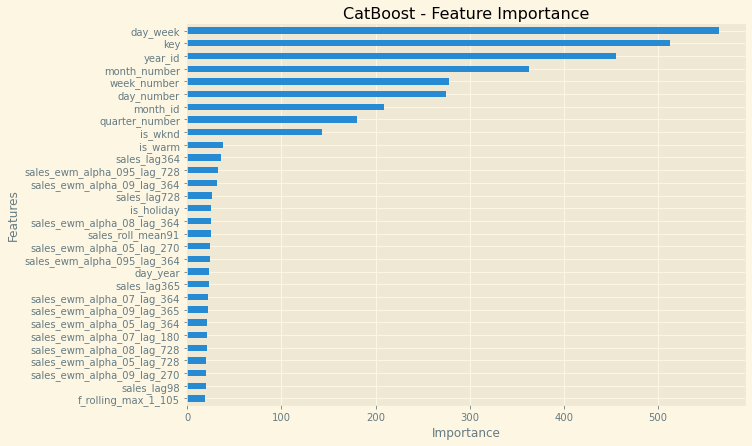

In [80]:
fea_imp = pd.DataFrame({'imp': model.feature_importances_, 'col': X.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
fea_imp.plot(kind='barh', x='col', y='imp', figsize=(10, 7), legend=None)
plt.title('CatBoost - Feature Importance')
plt.ylabel('Features')
plt.xlabel('Importance')

In [81]:
import datetime

preds_test = model.predict(x_test)
preds_test = pd.DataFrame(preds_test)
preds_test.columns = ['pred']

preds_test = x_test[['key','day_id']].reset_index(drop=True).merge(preds_test, left_index=True, right_index=True, how = 'left')
preds_test = preds_test.merge(y_test.reset_index(drop=True), left_index=True, right_index=True, how = 'left')

preds_test['day_id'] = pd.to_datetime(df['day_id'])

preds_test.head()

key     day_id        pred  y_interp3
0   2 2019-06-24  397.417768   533.8045
1   2 2019-06-25  363.989488   403.0000
2   1 2019-06-26  464.426907   497.0000
3   2 2019-06-27  518.871137   586.0000
4   5 2019-06-28  718.754206   589.0000

In [82]:
rmse = mean_squared_error(preds_test['y_interp3'], preds_test['pred'], squared=False)
mape = mean_absolute_percentage_error(preds_test['y_interp3'], preds_test['pred'])
wape = (preds_test['y_interp3'] - preds_test['pred']).abs().sum() / preds_test['y_interp3'].sum()

print(rmse)
print(mape)
print(wape)

62.13039274198571
0.07586247594491081
0.06328610005041851


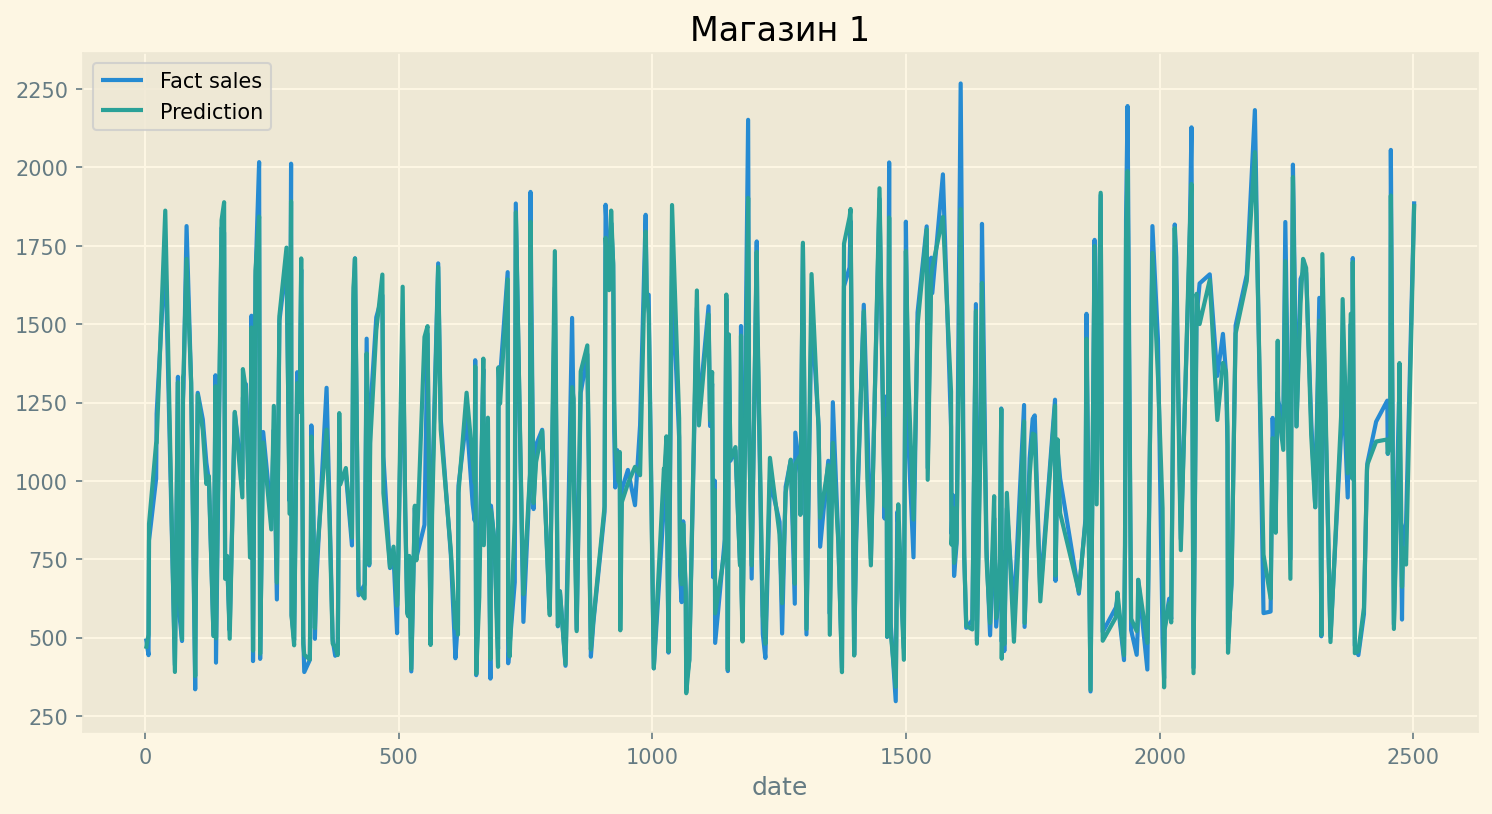

In [83]:
plt.figure(figsize=(12, 6), dpi=150)

preds_test.query('key==1')['y_interp3'].plot(label = 'Fact sales')
preds_test.query('key==1')['pred'].plot(label = 'Prediction')

plt.title('Магазин 1')
plt.xlabel('date')
plt.legend(loc='upper left')

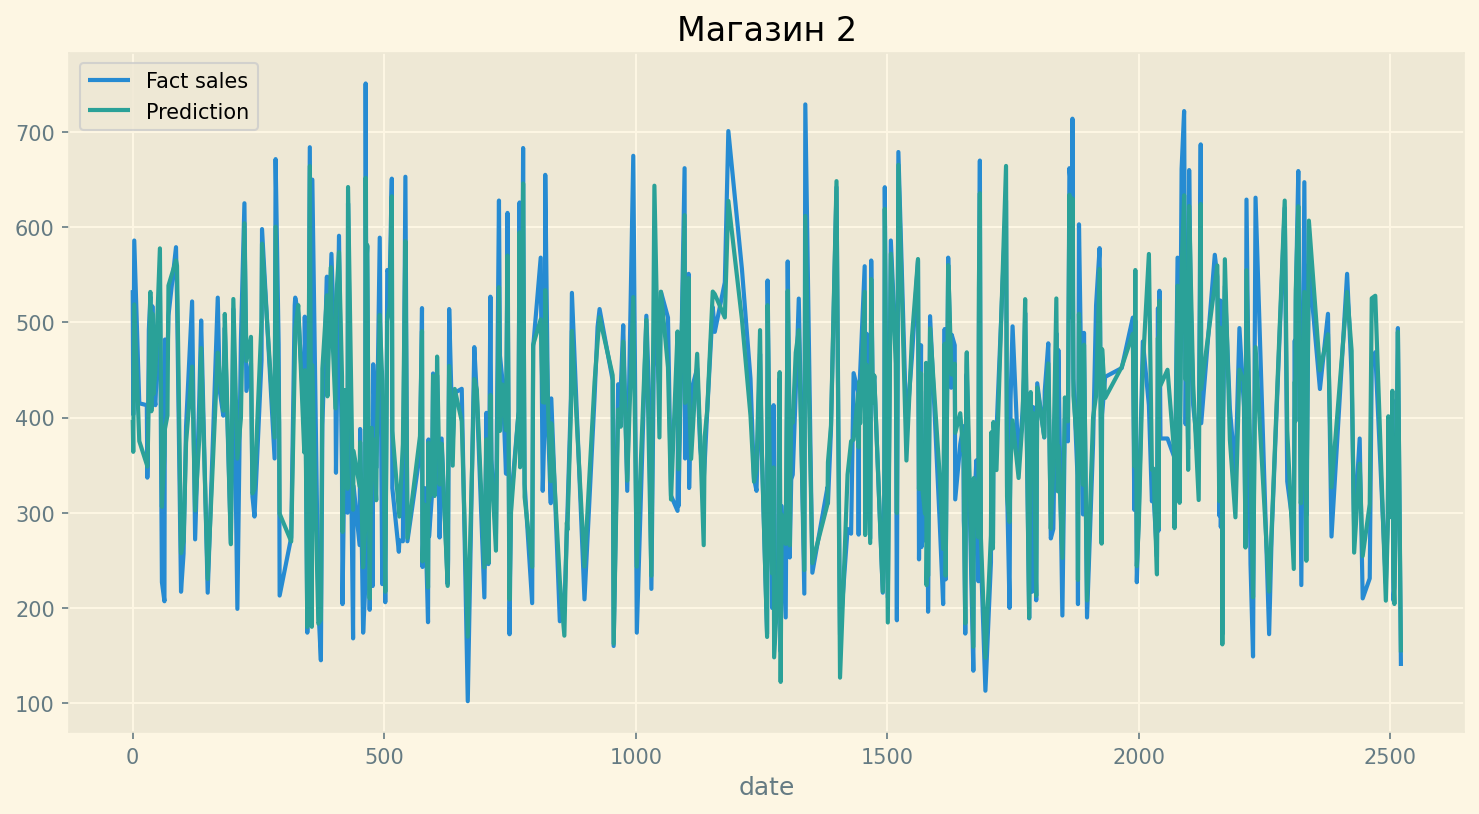

In [84]:
plt.figure(figsize=(12, 6), dpi=150)

preds_test.query('key==2')['y_interp3'].plot(label = 'Fact sales')
preds_test.query('key==2')['pred'].plot(label = 'Prediction')

plt.title('Магазин 2')
plt.xlabel('date')
plt.legend(loc='upper left')

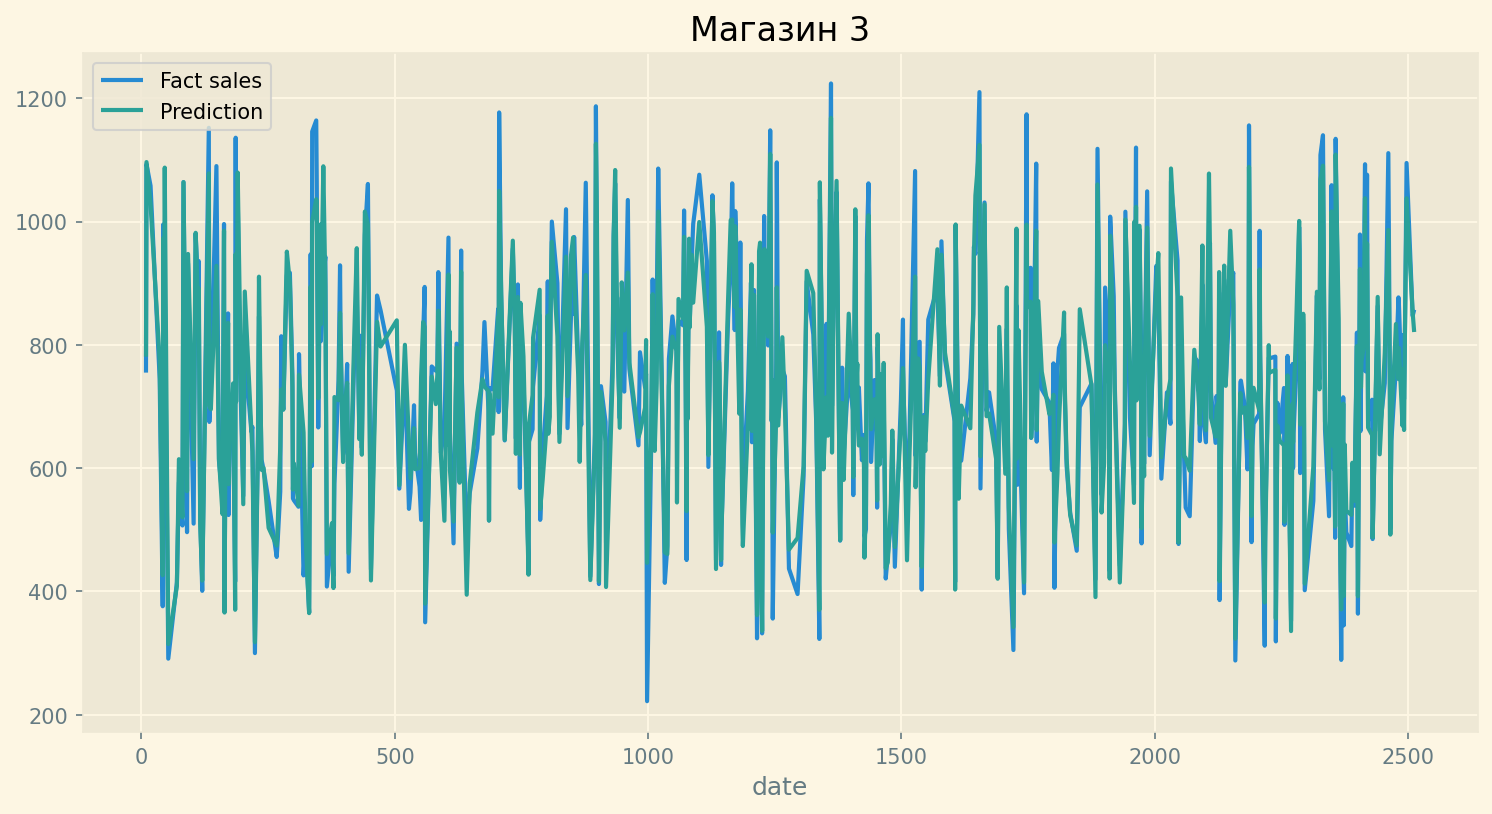

In [85]:
plt.figure(figsize=(12, 6), dpi=150)

preds_test.query('key==3')['y_interp3'].plot(label = 'Fact sales')
preds_test.query('key==3')['pred'].plot(label = 'Prediction')

plt.title('Магазин 3')
plt.xlabel('date')
plt.legend(loc='upper left')

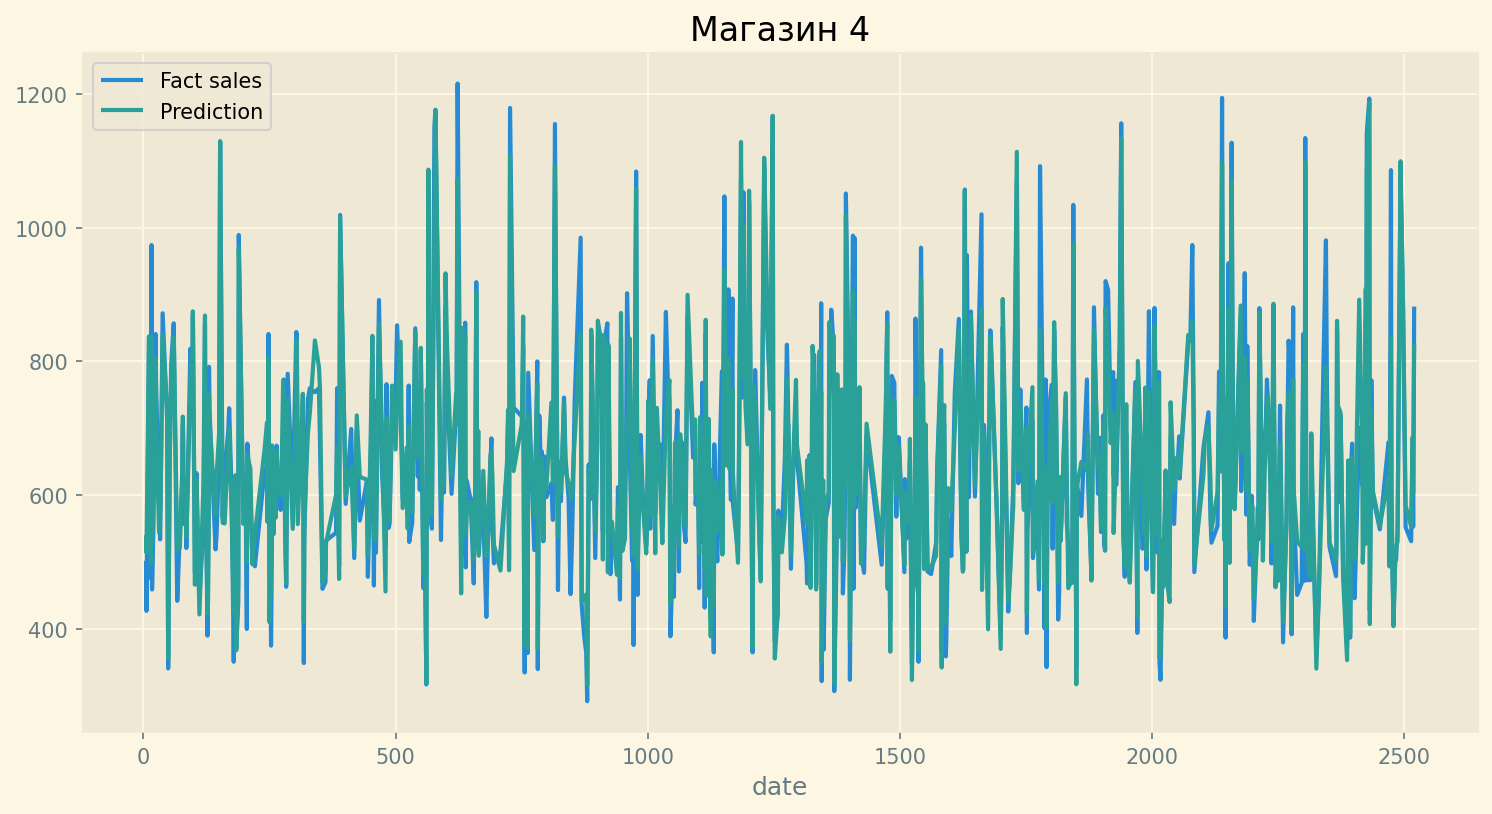

In [86]:
plt.figure(figsize=(12, 6), dpi=150)

preds_test.query('key==4')['y_interp3'].plot(label = 'Fact sales')
preds_test.query('key==4')['pred'].plot(label = 'Prediction')

plt.title('Магазин 4')
plt.xlabel('date')
plt.legend(loc='upper left')

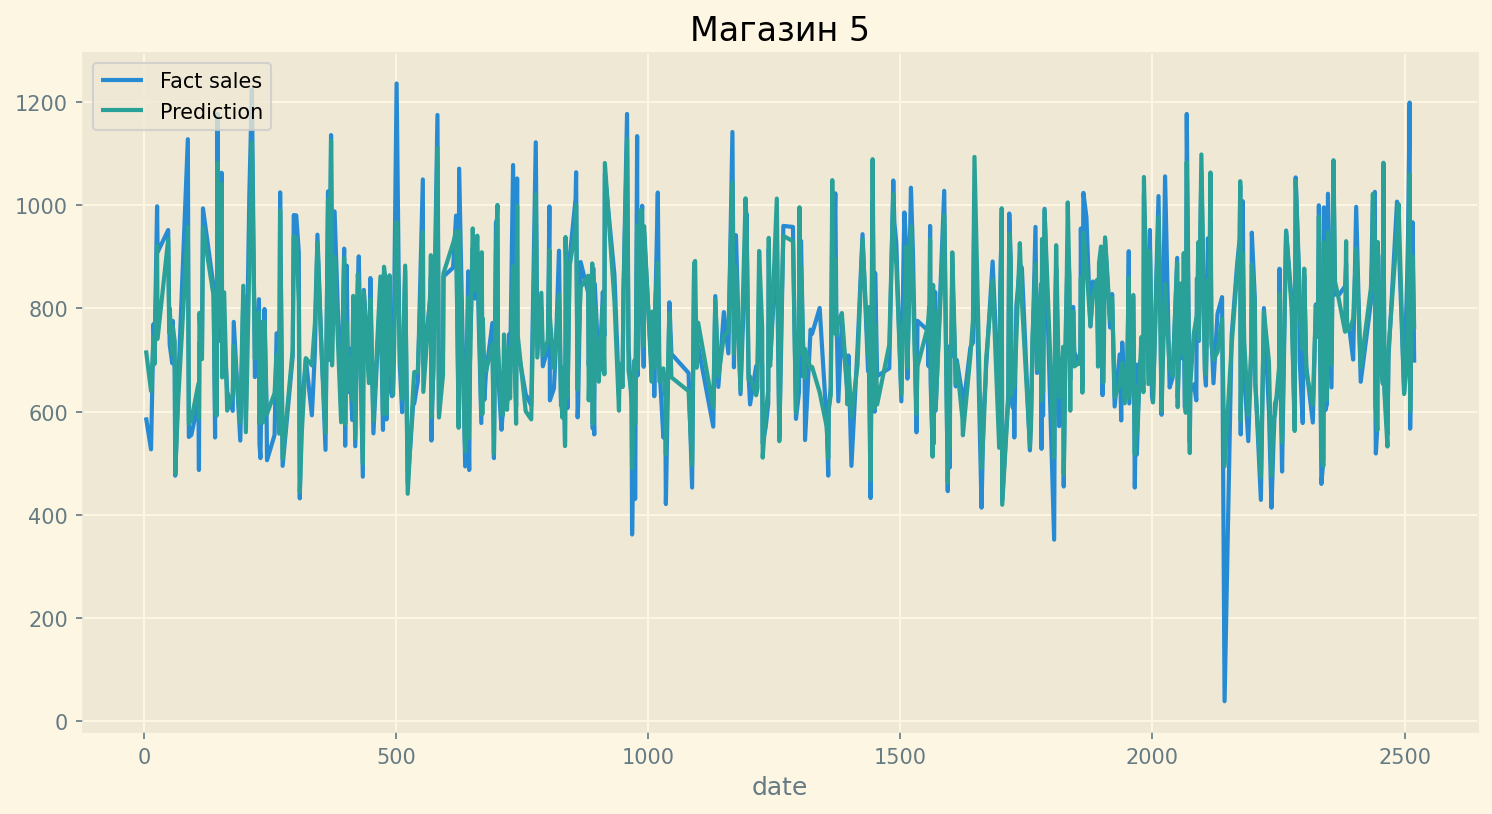

In [87]:
plt.figure(figsize=(12, 6), dpi=150)

preds_test.query('key==5')['y_interp3'].plot(label = 'Fact sales')
preds_test.query('key==5')['pred'].plot(label = 'Prediction')

plt.title('Магазин 5')
plt.xlabel('date')
plt.legend(loc='upper left')

# FINAL MODEL

In [92]:
X_train = df_train_test.drop(columns=['y','lower_y','upper_y','y_interp3'])  #,'y_sc'
Y_train = df_train_test['y_interp3']

In [106]:
import sklearn.datasets, sklearn.model_selection

LGBMR = LGBMRegressor(
    verbosity = -1,
    boosting_type = 'gbdt',
    linear_tree = True,    # добавляем новый параметр для определения тренда в данных
    objective = 'regression',
    categorical_feature = categories,
    n_estimators = 500,
    learning_rate = 0.08103424118044905,
    num_leaves = 422,
    max_depth = 12,
    min_data_in_leaf = 100,
    lambda_l1 = 100,
    lambda_l2 = 40,
    min_gain_to_split = 2.9752237272698427,
    bagging_fraction = 0.9,
    bagging_freq = 1,
    feature_fraction = 0.6000000000000001,
    random_state = 78,
    extra_trees = True
)

preds_sub = np.zeros(df_submission.shape[0])

cv_scores = np.empty(10)
cv = KFold(n_splits=10, shuffle=True, random_state=78)

for idx, (trn_idx, test_idx) in enumerate(cv.split(X_train, Y_train)):
    X_tr,X_val = X_train.iloc[trn_idx], X_train.iloc[test_idx]
    y_tr,y_val = Y_train.iloc[trn_idx], Y_train.iloc[test_idx]
    final_model = LGBMR
    final_model.fit(
        X_tr,
        y_tr,
        eval_set=[(X_val,y_val)],
        eval_metric='rmse',
        early_stopping_rounds=1,
    )
    preds = final_model.predict(X_val)
    # Сохраняем в массив результаты проверки
    cv_scores[idx] = mean_squared_error(y_val, preds.reshape(-1,1), squared=False)
    
np.mean(cv_scores)

[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_gain_to_split is set=2.9752237272698427, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.9752237272698427
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=100, reg_alpha=0.0 will be ignored. Current value: lambda_l1=100
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[1]	valid_0's rmse: 271.169	valid_0's l2: 73532.4
[2]	valid_0's rmse: 254.576	valid_0's l2: 64809.1
[3]	valid_0's rmse: 239.589	valid_0's 

[51]	valid_0's rmse: 88.4912	valid_0's l2: 7830.7
[52]	valid_0's rmse: 88.1632	valid_0's l2: 7772.75
[53]	valid_0's rmse: 87.912	valid_0's l2: 7728.51
[54]	valid_0's rmse: 87.6781	valid_0's l2: 7687.45
[55]	valid_0's rmse: 87.5103	valid_0's l2: 7658.05
[56]	valid_0's rmse: 87.2258	valid_0's l2: 7608.34
[57]	valid_0's rmse: 86.8723	valid_0's l2: 7546.79
[58]	valid_0's rmse: 86.5739	valid_0's l2: 7495.05
[59]	valid_0's rmse: 86.3572	valid_0's l2: 7457.56
[60]	valid_0's rmse: 86.0987	valid_0's l2: 7412.99
[61]	valid_0's rmse: 85.9139	valid_0's l2: 7381.2
[62]	valid_0's rmse: 85.7893	valid_0's l2: 7359.81
[63]	valid_0's rmse: 85.6465	valid_0's l2: 7335.32
[64]	valid_0's rmse: 85.4072	valid_0's l2: 7294.39
[65]	valid_0's rmse: 85.3402	valid_0's l2: 7282.95
[66]	valid_0's rmse: 85.1282	valid_0's l2: 7246.82
[67]	valid_0's rmse: 84.8224	valid_0's l2: 7194.84
[68]	valid_0's rmse: 84.7956	valid_0's l2: 7190.29
[69]	valid_0's rmse: 84.6016	valid_0's l2: 7157.44
[70]	valid_0's rmse: 84.3646	valid

[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_gain_to_split is set=2.9752237272698427, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.9752237272698427
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=100, reg_alpha=0.0 will be ignored. Current value: lambda_l1=100
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[1]	valid_0's rmse: 304.094	valid_0's l2: 92473.3
[2]	valid_0's rmse: 286.097	valid_0's l2: 81851.3
[3]	valid_0's rmse: 268.609	valid_0's 

[50]	valid_0's rmse: 85.5055	valid_0's l2: 7311.19
[51]	valid_0's rmse: 84.9397	valid_0's l2: 7214.76
[52]	valid_0's rmse: 84.7342	valid_0's l2: 7179.88
[53]	valid_0's rmse: 84.5544	valid_0's l2: 7149.44
[54]	valid_0's rmse: 84.3612	valid_0's l2: 7116.81
[55]	valid_0's rmse: 84.1052	valid_0's l2: 7073.68
[56]	valid_0's rmse: 83.6906	valid_0's l2: 7004.12
[57]	valid_0's rmse: 83.4144	valid_0's l2: 6957.96
[58]	valid_0's rmse: 83.0912	valid_0's l2: 6904.14
[59]	valid_0's rmse: 82.9354	valid_0's l2: 6878.28
[60]	valid_0's rmse: 82.692	valid_0's l2: 6837.97
[61]	valid_0's rmse: 82.4554	valid_0's l2: 6798.89
[62]	valid_0's rmse: 82.2746	valid_0's l2: 6769.1
[63]	valid_0's rmse: 82.1215	valid_0's l2: 6743.94
[64]	valid_0's rmse: 81.9952	valid_0's l2: 6723.21
[65]	valid_0's rmse: 81.8771	valid_0's l2: 6703.85
[66]	valid_0's rmse: 81.7183	valid_0's l2: 6677.88
[67]	valid_0's rmse: 81.5583	valid_0's l2: 6651.75
[68]	valid_0's rmse: 81.3704	valid_0's l2: 6621.14
[69]	valid_0's rmse: 81.2096	vali

[57]	valid_0's rmse: 86.714	valid_0's l2: 7519.31
[58]	valid_0's rmse: 86.445	valid_0's l2: 7472.74
[59]	valid_0's rmse: 86.2987	valid_0's l2: 7447.46
[60]	valid_0's rmse: 86.1928	valid_0's l2: 7429.2
[61]	valid_0's rmse: 85.8456	valid_0's l2: 7369.47
[62]	valid_0's rmse: 85.6869	valid_0's l2: 7342.25
[63]	valid_0's rmse: 85.5655	valid_0's l2: 7321.45
[64]	valid_0's rmse: 85.4182	valid_0's l2: 7296.28
[65]	valid_0's rmse: 85.2284	valid_0's l2: 7263.88
[66]	valid_0's rmse: 85.1248	valid_0's l2: 7246.24
[67]	valid_0's rmse: 84.8823	valid_0's l2: 7205.01
[68]	valid_0's rmse: 84.7476	valid_0's l2: 7182.15
[69]	valid_0's rmse: 84.714	valid_0's l2: 7176.46
[70]	valid_0's rmse: 84.4855	valid_0's l2: 7137.79
[71]	valid_0's rmse: 84.2352	valid_0's l2: 7095.57
[72]	valid_0's rmse: 84.1045	valid_0's l2: 7073.56
[73]	valid_0's rmse: 84.1642	valid_0's l2: 7083.61
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.

[39]	valid_0's rmse: 91.1798	valid_0's l2: 8313.75
[40]	valid_0's rmse: 90.4123	valid_0's l2: 8174.38
[41]	valid_0's rmse: 89.9234	valid_0's l2: 8086.21
[42]	valid_0's rmse: 89.3234	valid_0's l2: 7978.67
[43]	valid_0's rmse: 88.9466	valid_0's l2: 7911.5
[44]	valid_0's rmse: 88.3264	valid_0's l2: 7801.56
[45]	valid_0's rmse: 87.8623	valid_0's l2: 7719.79
[46]	valid_0's rmse: 87.6805	valid_0's l2: 7687.86
[47]	valid_0's rmse: 87.1916	valid_0's l2: 7602.38
[48]	valid_0's rmse: 86.8452	valid_0's l2: 7542.1
[49]	valid_0's rmse: 86.5122	valid_0's l2: 7484.36
[50]	valid_0's rmse: 85.9601	valid_0's l2: 7389.14
[51]	valid_0's rmse: 85.6624	valid_0's l2: 7338.05
[52]	valid_0's rmse: 85.2809	valid_0's l2: 7272.83
[53]	valid_0's rmse: 85.0921	valid_0's l2: 7240.66
[54]	valid_0's rmse: 84.8642	valid_0's l2: 7201.93
[55]	valid_0's rmse: 84.6947	valid_0's l2: 7173.19
[56]	valid_0's rmse: 84.4326	valid_0's l2: 7128.86
[57]	valid_0's rmse: 84.2614	valid_0's l2: 7099.99
[58]	valid_0's rmse: 83.9556	vali

[84]	valid_0's rmse: 78.1369	valid_0's l2: 6105.38
[85]	valid_0's rmse: 77.9141	valid_0's l2: 6070.6
[86]	valid_0's rmse: 77.5037	valid_0's l2: 6006.82
[87]	valid_0's rmse: 77.3546	valid_0's l2: 5983.74
[88]	valid_0's rmse: 77.2934	valid_0's l2: 5974.27
[89]	valid_0's rmse: 77.1772	valid_0's l2: 5956.32
[90]	valid_0's rmse: 77.0268	valid_0's l2: 5933.13
[91]	valid_0's rmse: 76.9017	valid_0's l2: 5913.87
[92]	valid_0's rmse: 76.8688	valid_0's l2: 5908.81
[93]	valid_0's rmse: 76.7675	valid_0's l2: 5893.26
[94]	valid_0's rmse: 76.6255	valid_0's l2: 5871.47
[95]	valid_0's rmse: 76.423	valid_0's l2: 5840.47
[96]	valid_0's rmse: 76.2053	valid_0's l2: 5807.24
[97]	valid_0's rmse: 76.1098	valid_0's l2: 5792.7
[98]	valid_0's rmse: 76.0433	valid_0's l2: 5782.58
[99]	valid_0's rmse: 75.9781	valid_0's l2: 5772.67
[100]	valid_0's rmse: 75.8828	valid_0's l2: 5758.2
[101]	valid_0's rmse: 75.7501	valid_0's l2: 5738.07
[102]	valid_0's rmse: 75.6569	valid_0's l2: 5723.97
[103]	valid_0's rmse: 75.456	val

87.35878206275507

In [107]:
preds_sub = final_model.predict(df_submission)
preds_sub = pd.DataFrame(preds_sub, columns = ['pred_final'])
submission = pd.concat([df_submission[['day_id','key']].reset_index(drop=True), preds_sub], axis = 1)
submission['day_id'] = pd.to_datetime(submission['day_id'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d')))
submission.head()

day_id key   pred_final
0 2023-08-01   1  1937.216806
1 2023-08-02   1  1720.063650
2 2023-08-03   1  1573.472858
3 2023-08-04   1  1258.510650
4 2023-08-05   1  1364.901273

In [103]:
#submission.to_excel(r'C:\Users\vadim.sokolov\Desktop\В\test5\submission.xlsx')

In [ ]:
df_train_test['day_id'] = pd.to_datetime(df_train_test['day_id'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d')))

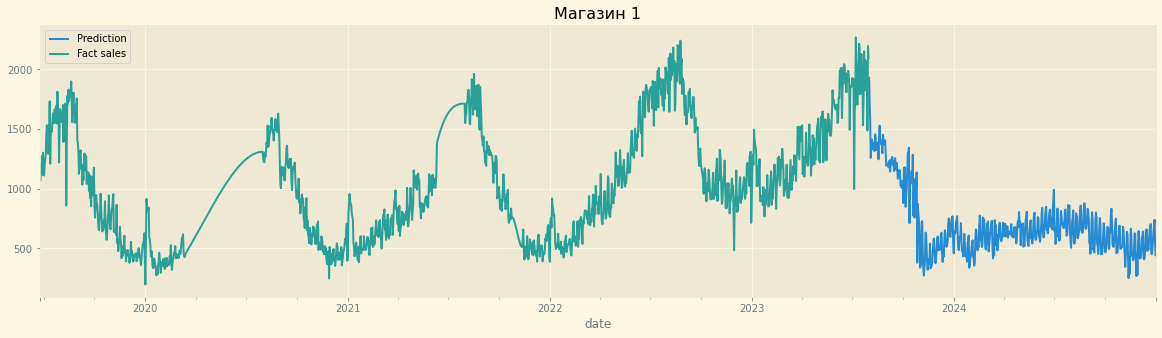

In [108]:
fig, ax = plt.subplots(figsize=(20,5))

submission.query('key==1').plot(ax=ax, label = 'Prediction', x='day_id', y='pred_final')
df_train_test.query('key==1').plot(ax=ax, label = 'Fact sales', x='day_id', y='y_interp3')

plt.title('Магазин 1')
plt.xlabel('date')
plt.legend(loc='upper left')

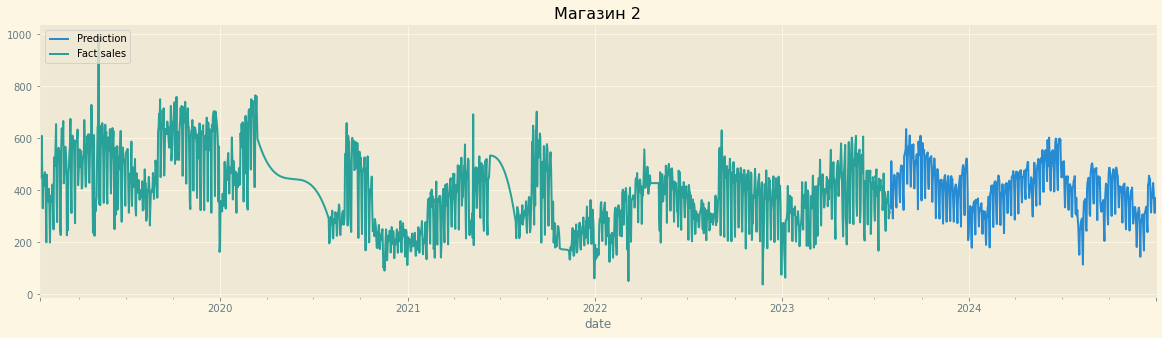

In [109]:
fig, ax = plt.subplots(figsize=(20,5))

submission.query('key==2').plot(ax=ax, label = 'Prediction', x='day_id', y='pred_final')
df_train_test.query('key==2').plot(ax=ax, label = 'Fact sales', x='day_id', y='y_interp3')

plt.title('Магазин 2')
plt.xlabel('date')
plt.legend(loc='upper left')

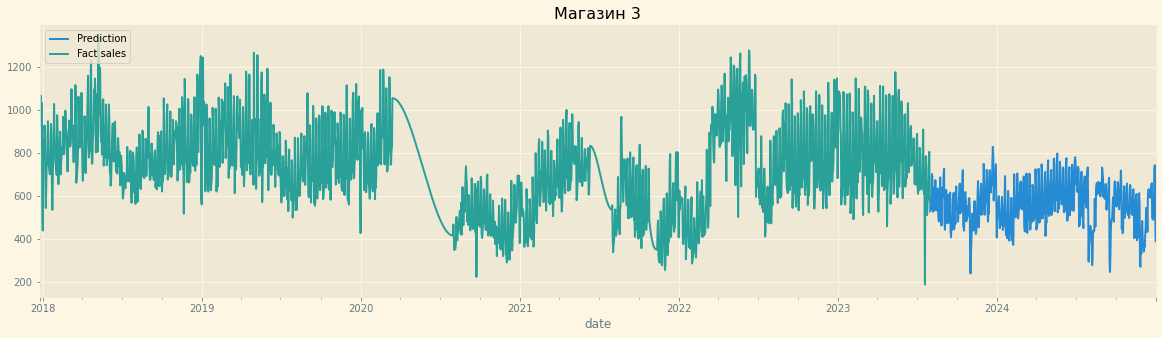

In [98]:
fig, ax = plt.subplots(figsize=(20,5))

submission.query('key==3').plot(ax=ax, label = 'Prediction', x='day_id', y='pred_final')
df_train_test.query('key==3').plot(ax=ax, label = 'Fact sales', x='day_id', y='y_interp3')

plt.title('Магазин 3')
plt.xlabel('date')
plt.legend(loc='upper left')

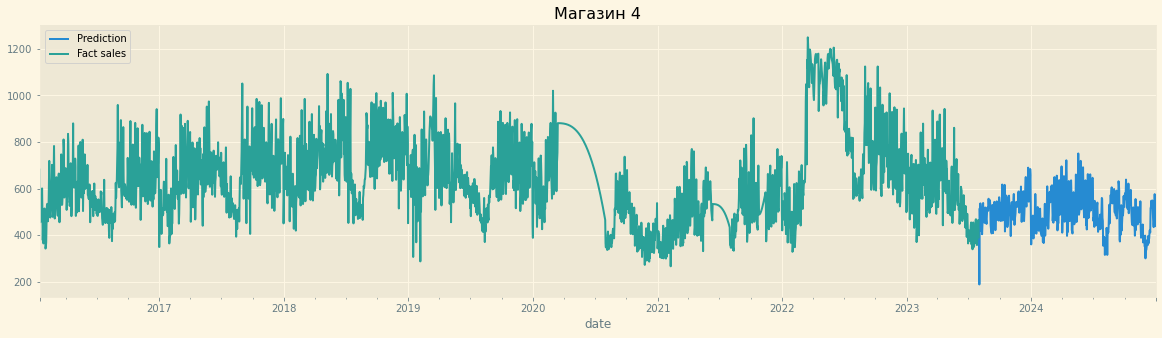

In [99]:
fig, ax = plt.subplots(figsize=(20,5))

submission.query('key==4').plot(ax=ax, label = 'Prediction', x='day_id', y='pred_final')
df_train_test.query('key==4').plot(ax=ax, label = 'Fact sales', x='day_id', y='y_interp3')

plt.title('Магазин 4')
plt.xlabel('date')
plt.legend(loc='upper left')

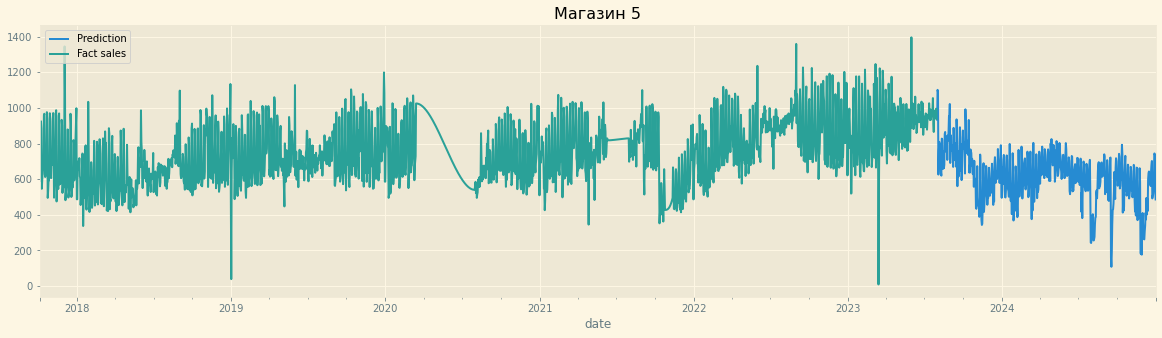

In [100]:
fig, ax = plt.subplots(figsize=(20,5))

submission.query('key==5').plot(ax=ax, label = 'Prediction', x='day_id', y='pred_final')
df_train_test.query('key==5').plot(ax=ax, label = 'Fact sales', x='day_id', y='y_interp3')

plt.title('Магазин 5')
plt.xlabel('date')
plt.legend(loc='upper left')